![image](https://py-rates.fr/assets/welcomePage/logoSmall.png)

# PyratesIA - Model Training

This notebook preprocesses the features vector and train the help policies, defined as multiclass classifiers that predicts from the behavioral features, the help type to provide to the students. 
- Input: The pickles generated by the feature_engineering notebook (pickle/FEATURES, pickle/FEATURES_CONSTANTS, pickle/RECEIVED_HELP_KEYS, pickle/FEATURES_SETS_KEY, pickle/LEVELS_KEYS, pickle/TIME_FEATURES_KEYS_TOTAL) 
- Output: A dictionary with the trained models, their performance, and their predicted values on the test sets

The inputs should be as follows:
<!-- - pickle/FEATURES_CONSTANTS: the list of feature names, along with the labels (in our case "help_type") and the student ID 'in our case "student_id") -->
- pickle/RECEIVED_HELP_KEYS: the different possible value of the labels (in our case the different help types)
<!-- - pickle/FEATURES: A nested dictionary with the game levels as the first keys ("Level1", "Level2"...), feature sets as the second keys ("sum_features_nohelp", "meansd_features_nohelp"), the feature names as the third keys ("CO_avg_while_impl", "CO_avg_string_impl"...), and the computed features as the values. -->
- pickle/FEATURES: A nested dictionary with the game levels as the first keys ("Level1", "Level2"...), and the feature names as the seconde keys
  ("CO_avg_while_impl", "CO_avg_string_impl"...), and the computed features as the values.
- pickle/LEVELS_KEYS: the list of level keys, i.e., the first keys in pickle/FEATURES 
<!-- - pickle/FEATURES_SETS_KEY: the list of feature sets names, i.e., the second key in pickle/FEATURES. This is relevant only if different subsets of features are used for model training. In case only one set of features is needed, then this should just be a list with only one element (the name of the one feature set). -->
- pickle/FEATURES_SETS_KEY: the list of feature sets name. This is relevant only if different subsets of features are used for model training. In case only one set of features is needed, then this should just be a list with only one element (the name of the one feature set).
- pickle/TIME_FEATURES_KEYS_TOTAL: the time-based features keys, that we discretize for some classifiers
<!-- - pickle/LABELS_KEY : the key of the label in the pickle/FEATURES dictionary -->

The output is as follows:

    outputall = {
        "grid_results": levels_results_grid,    
        "grid_trained_classifiers": levels_grid_classifier,
        "grid_predictions": pred_results,
        "grid_true_labels": pred_labels
    }
where:
- grid_results is a dataframe with the performance of the models (by default we compute  F1 score, precision, recall)
- grid_trained_classifiers is a nested dictionary with the trained models per game level (1st key), feature sets (2nd key) and model (3rd key). When using k-folds the value is a list of model (one per fold)
- grid_predictions is a similar dictionary where the value are the model's prediction (i.e., the outputs of the models)
- grid_true_labels is the same as grid_predictions but with the true labels (necessary to compute confusing matrices)
    

In [115]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
%matplotlib inline
from dateutil import parser
from locale import normalize
import ipywidgets as widgets
from IPython import display
from statistics import mean
import pickle
import dill

from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupShuffleSplit
# from modules.ordinal import OrdinalClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE 
from copy import deepcopy

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

from sklearn.inspection import permutation_importance
import shap


pd.options.display.max_rows = 999 #to be able to print full matrices
# from dill import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

## 1) Load Pickles

In [116]:
# with open('pickle/FEATURES_CONSTANTS', 'rb') as f:
#     ALL_KEYS = pickle.load(f)

with open('pickle/FEATURES', 'rb') as f:
    levels_processed_dataframes = pickle.load(f)
    
# with open('pickle/LABELS_KEY', 'rb') as f:
#     LABELS_KEY = pickle.load(f)
    
with open('pickle/FEATURES_SETS_KEY', 'rb') as f:
    FEATURES_SETS = pickle.load(f)
    
with open('pickle/LEVELS_KEYS', 'rb') as f:
    LEVELS_KEYS = pickle.load(f)  
        
with open('pickle/RECEIVED_HELP_KEYS', 'rb') as f:
    RECEIVED_HELP_KEYS = pickle.load(f)
    
with open('pickle/TIME_FEATURES_KEYS_TOTAL', 'rb') as f:
    TIME_FEATURES_KEYS_TOTAL = pickle.load(f)  

## 2) Constants

ML Constants

In [117]:
RAND_STATE_SEED = 42 #for reproducibility
EXPORT_SUFFIX = "_run10" #suffix to add to all exported file (for version control)
NBFOLDS = 5 # number of cross validation folds
NBFOLDS_GRID = 5 # number of inner folds for the grid search hyperparameter tuning
LABELS_KEY = "help_type" # the key of the labels in the feature dataframe
STUDENT_ID_KEY = "game_id" # the grouping key used to do cross-validation over users (effectively using the StratifiedGroupKFold function of Sklearn)
BASELINE_FEATURE_SET = "baseline_set" # the grouping key used to do cross-validation over users (effectively using the StratifiedGroupKFold function of Sklearn)
CORREL_THRESHOLD = 0.8 # thresholds for discarding correlated features (1 means no feature removal) 
SMOTE_MINORITY = False # True/False: to turn on/off Smote over-sampling of the minority classes
ALL_LEVEL_KEY = "All_Level" #Add a dataframe with all game levels combined. Keep empty to ignore.
MAX_EXECUTION_THRESHOLD = 40 # outlier threshold: students who made too many executions are deemed outliers because this can reveals a gaming-the-system strategy

Select feature sets (see features_engineering for the list of possible sets)

To keep them all, do FEATURES_SETS_KEEP_FOR_ML = FEATURES_SETS

In [118]:
#FEATURES_SETS_KEEP_FOR_ML = FEATURES_SETS

FEATURES_SETS_KEEP_FOR_ML = [
    "mean_sd_rate_features_nohelp_nosub", #all features
    "mean_rate_features_nohelp_nosub", #all features minus std.dev ones
    
    #Less modalities subsets (IB vs. OA)
    "mean_sd_rate_ib_no_sub_content_features_keys", #all IB features
    "mean_sd_rate_oa_features_keys", #all OA features
    "mean_rate_ib_no_sub_content_features_keys", #all IB features minus std.dev ones
    "mean_rate_oa_features_keys" #all OA features minus std.dev ones
]

#test
#FEATURES_SETS_KEEP_FOR_ML = [
#    "mean_rate_features_nohelp_nosub"]

FEATURES_SETS_KEEP_FOR_ML += [BASELINE_FEATURE_SET] #keep baseline features set

Feature keys required for ML:

In [119]:
NB_USER_STOPPED_EXECUTION_KEY = "EX_tot_user_stopped"
NB_COMPLETED_EXECUTION_KEY = "EX_tot_executed"
REQUESTED_HELP_TOTAL = "FE_tot_requested"

## 3) Data filtering and outlier removal

Remove game levels where the amount of datapoints (help delivered) is too small,
either because the level is too easy, or because not enough students made it to
that level

In [120]:
# We opted to remove the game levels where the number of datapoints is substantially lower, 
# effectively less than 50 datapoints (see features_exploration).
del levels_processed_dataframes[LEVELS_KEYS[1]] #level2
del levels_processed_dataframes[LEVELS_KEYS[5]] #level6
del levels_processed_dataframes[LEVELS_KEYS[6]] #level7
del levels_processed_dataframes[LEVELS_KEYS[7]] #level8

Remove outliers, defined as rows with too many executions (indicates a notion avoidance strategy: user playing with random)

In [121]:

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    nb_rows_before = level_processed_dataframe.shape[0]
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_USER_STOPPED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    level_processed_dataframe = level_processed_dataframe.drop(level_processed_dataframe[level_processed_dataframe[NB_COMPLETED_EXECUTION_KEY] > MAX_EXECUTION_THRESHOLD].index)
    nb_rows_after = level_processed_dataframe.shape[0]
    print("Nb deleted rows: ",(nb_rows_before-nb_rows_after))


------------------ Level1 ------------------
Nb deleted rows:  0
------------------ Level3 ------------------
Nb deleted rows:  0
------------------ Level4 ------------------
Nb deleted rows:  3
------------------ Level5 ------------------
Nb deleted rows:  9


Lump levels together to make predictions across levels (ALL_LEVEL_KEY):

In [122]:
if ALL_LEVEL_KEY:
    to_concat = []
    for level_key, level_processed_dataframe in levels_processed_dataframes.items():
        to_concat.append(level_processed_dataframe)


    levels_processed_dataframes[ALL_LEVEL_KEY] = pd.concat(to_concat)

In [123]:
#check levels
levels_processed_dataframes.keys()

dict_keys(['Level1', 'Level3', 'Level4', 'Level5', 'All_Level'])

## 4) Create the feature sets

Here a feature set is defined as a subset of the features (i.e., a subset of pickle/FEATURES_CONSTANTS). The goal being to train the models on different subsets of features rather than just using all of the available features.

In [124]:
# Based on the levels_processed_dataframes dataframe, create one dataframe per feature set defined above in FEATURES_SETS

levels_featuresets_dataframes = {}
print("-------------------------------------(nbdatapoints, nbfeatures)")
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    levels_featuresets_dataframes[level_key] = {}
    for fset_key, fset_columns in FEATURES_SETS.items():
        if len(FEATURES_SETS_KEEP_FOR_ML) > 0 and fset_key in FEATURES_SETS_KEEP_FOR_ML:
            levels_featuresets_dataframes[level_key][fset_key] = level_processed_dataframe[fset_columns]
            print(level_key, "-", fset_key, ": ", levels_featuresets_dataframes[level_key][fset_key].shape)
    print()

#levels_featuresets_dataframes["Level1"]["sum_features_help_received"]

-------------------------------------(nbdatapoints, nbfeatures)
Level1 - mean_sd_rate_features_nohelp_nosub :  (176, 108)
Level1 - mean_rate_features_nohelp_nosub :  (176, 65)
Level1 - mean_sd_rate_ib_no_sub_content_features_keys :  (176, 41)
Level1 - mean_sd_rate_oa_features_keys :  (176, 75)
Level1 - mean_rate_ib_no_sub_content_features_keys :  (176, 31)
Level1 - mean_rate_oa_features_keys :  (176, 39)
Level1 - baseline_set :  (176, 8)

Level3 - mean_sd_rate_features_nohelp_nosub :  (408, 108)
Level3 - mean_rate_features_nohelp_nosub :  (408, 65)
Level3 - mean_sd_rate_ib_no_sub_content_features_keys :  (408, 41)
Level3 - mean_sd_rate_oa_features_keys :  (408, 75)
Level3 - mean_rate_ib_no_sub_content_features_keys :  (408, 31)
Level3 - mean_rate_oa_features_keys :  (408, 39)
Level3 - baseline_set :  (408, 8)

Level4 - mean_sd_rate_features_nohelp_nosub :  (338, 108)
Level4 - mean_rate_features_nohelp_nosub :  (338, 65)
Level4 - mean_sd_rate_ib_no_sub_content_features_keys :  (338, 41)

In [125]:
#Display list of features
levels_featuresets_dataframes["Level1"]["mean_rate_features_nohelp_nosub"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 65 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CO_avg_base_disp_time                176 non-null    float64
 1   CO_avg_var_disp_time                 176 non-null    float64
 2   CO_avg_condi_disp_time               176 non-null    float64
 3   CO_avg_for_disp_time                 176 non-null    float64
 4   CO_avg_while_disp_time               176 non-null    float64
 5   CO_rate_code_editor_copied           176 non-null    float64
 6   CO_rate_control_function_copied      176 non-null    float64
 7   CO_rate_base_program_copied          176 non-null    float64
 8   CO_rate_base_error_copied            176 non-null    float64
 9   CO_rate_base_structuration_copied    176 non-null    float64
 10  CO_rate_base_comment_copied          176 non-null    float64
 11  CO_rate_var_creation_copied     

## 5) ML pipeline steps

### 5.1) Create the k-folds group

By default we used stratified k-folds over students. Stratification means that the label distribution remains balanced across the groups. "Over students" means that all of the datapoints pertaining to a student (eg all of the help they received) are within the same fold, to avoid data contamination.

In [126]:
levels_train_sets = {}
levels_test_sets = {}
level_train_set_index = []
level_test_set_index = []
cv_split_indices = {}
# test_set_ratio = 1.0 / NBFOLDS
# print("test_set_ratio = ", test_set_ratio)

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    cv_split_indices[level_key] = []
    # Detour of StratifiedGroupKFold to get stratified AND group aware train-test split
    cv = StratifiedGroupKFold(n_splits=NBFOLDS,shuffle=True, random_state = RAND_STATE_SEED)
    for level_train_set_index, level_test_set_index in cv.split(level_processed_dataframe,y=level_processed_dataframe[LABELS_KEY], groups=level_processed_dataframe[STUDENT_ID_KEY]):
        cv_split_indices[level_key].append( (level_train_set_index, level_test_set_index) )
       
# Print the fold sizes
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
        print(k, ": ", len(level_train_set_index), "/", len(level_test_set_index))
        #print (cv_split_indices[level_key][k][1])

------------------ Level1 ------------------
0 :  143 / 33
1 :  146 / 30
2 :  141 / 35
3 :  141 / 35
4 :  133 / 43
------------------ Level3 ------------------
0 :  330 / 78
1 :  324 / 84
2 :  330 / 78
3 :  317 / 91
4 :  331 / 77
------------------ Level4 ------------------
0 :  268 / 70
1 :  279 / 59
2 :  268 / 70
3 :  271 / 67
4 :  266 / 72
------------------ Level5 ------------------
0 :  127 / 37
1 :  129 / 35
2 :  128 / 36
3 :  133 / 31
4 :  139 / 25
------------------ All_Level ------------------
0 :  884 / 202
1 :  854 / 232
2 :  870 / 216
3 :  847 / 239
4 :  889 / 197


------------------ Level1 ------------------


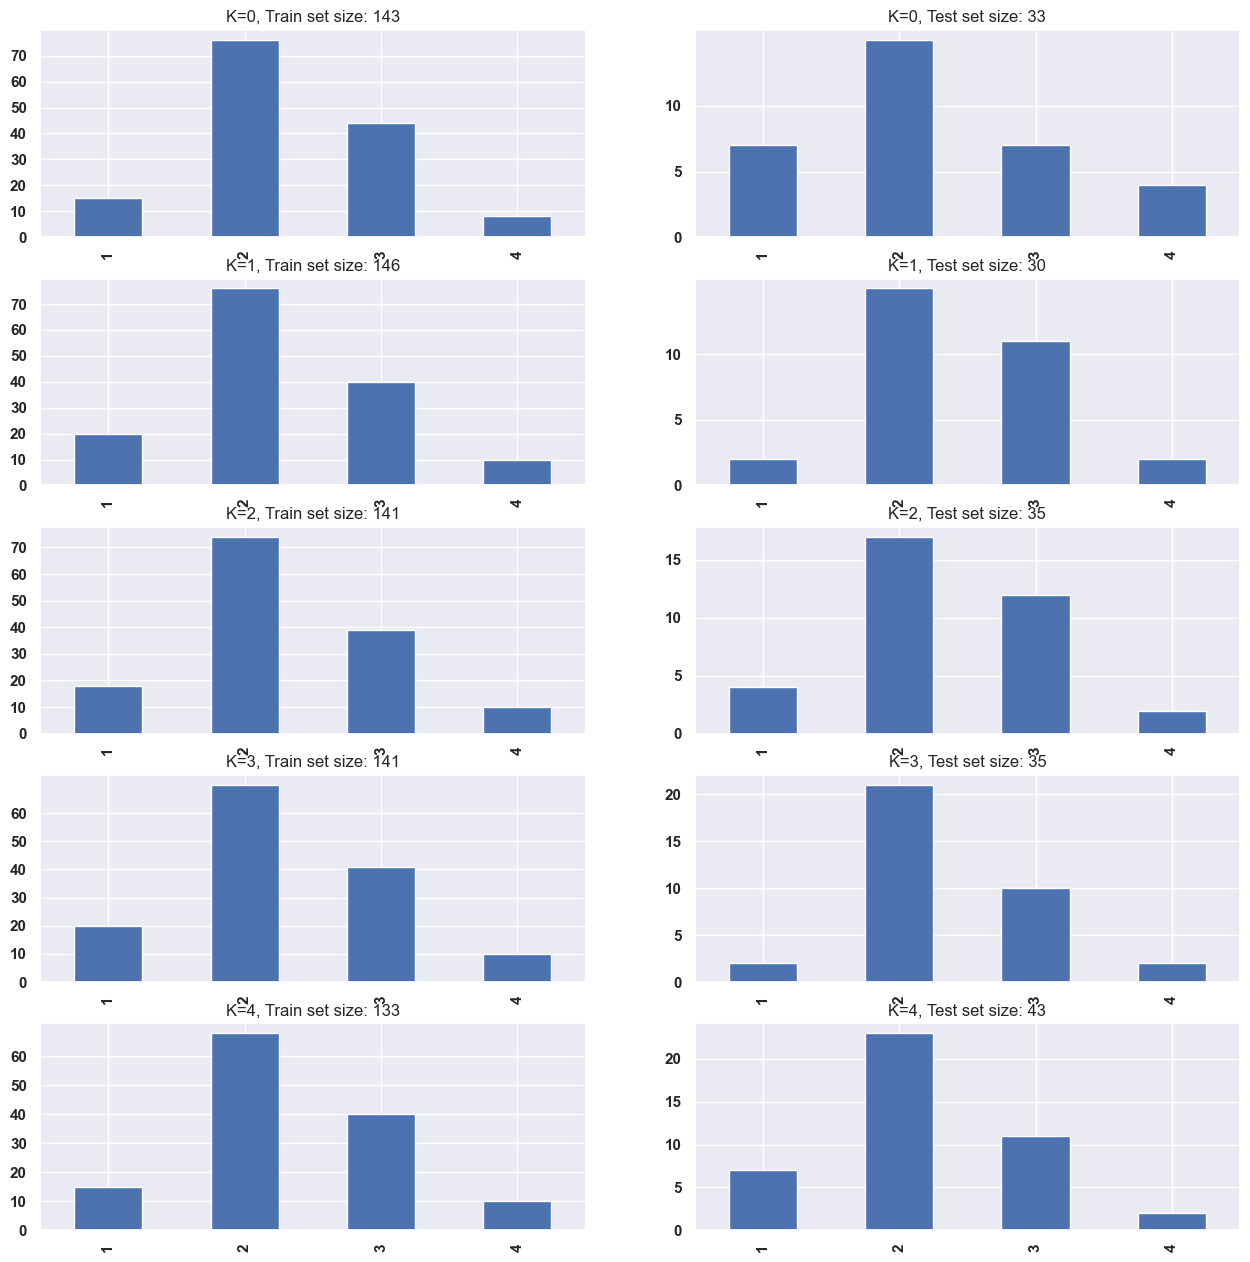

------------------ Level3 ------------------


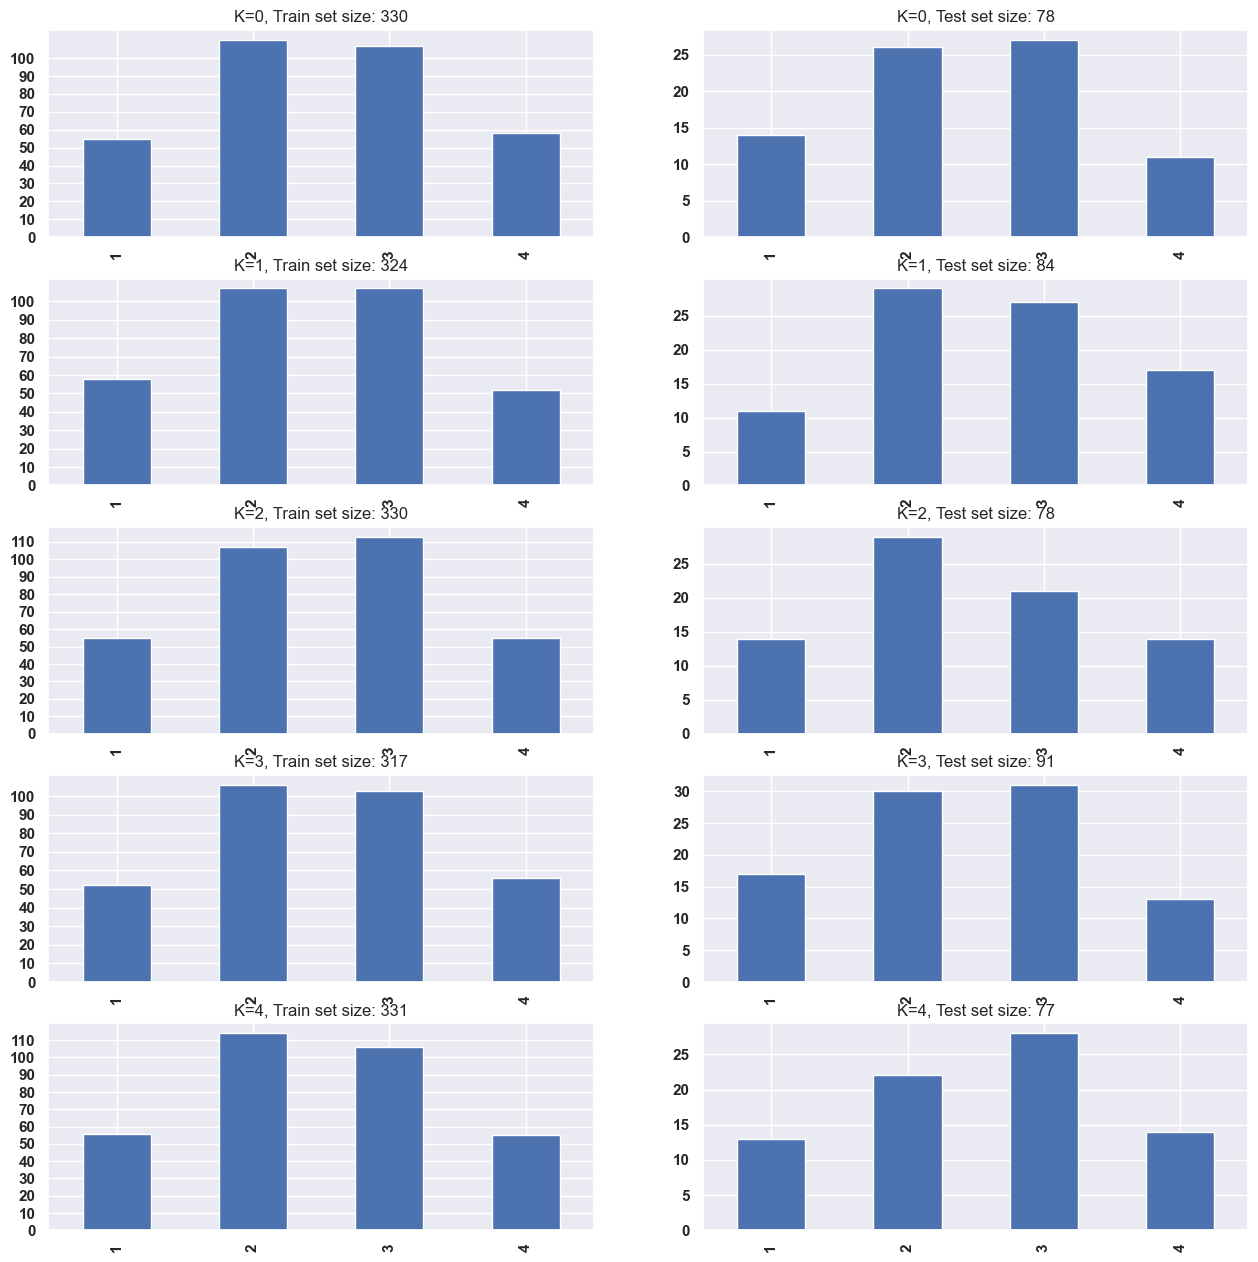

------------------ Level4 ------------------


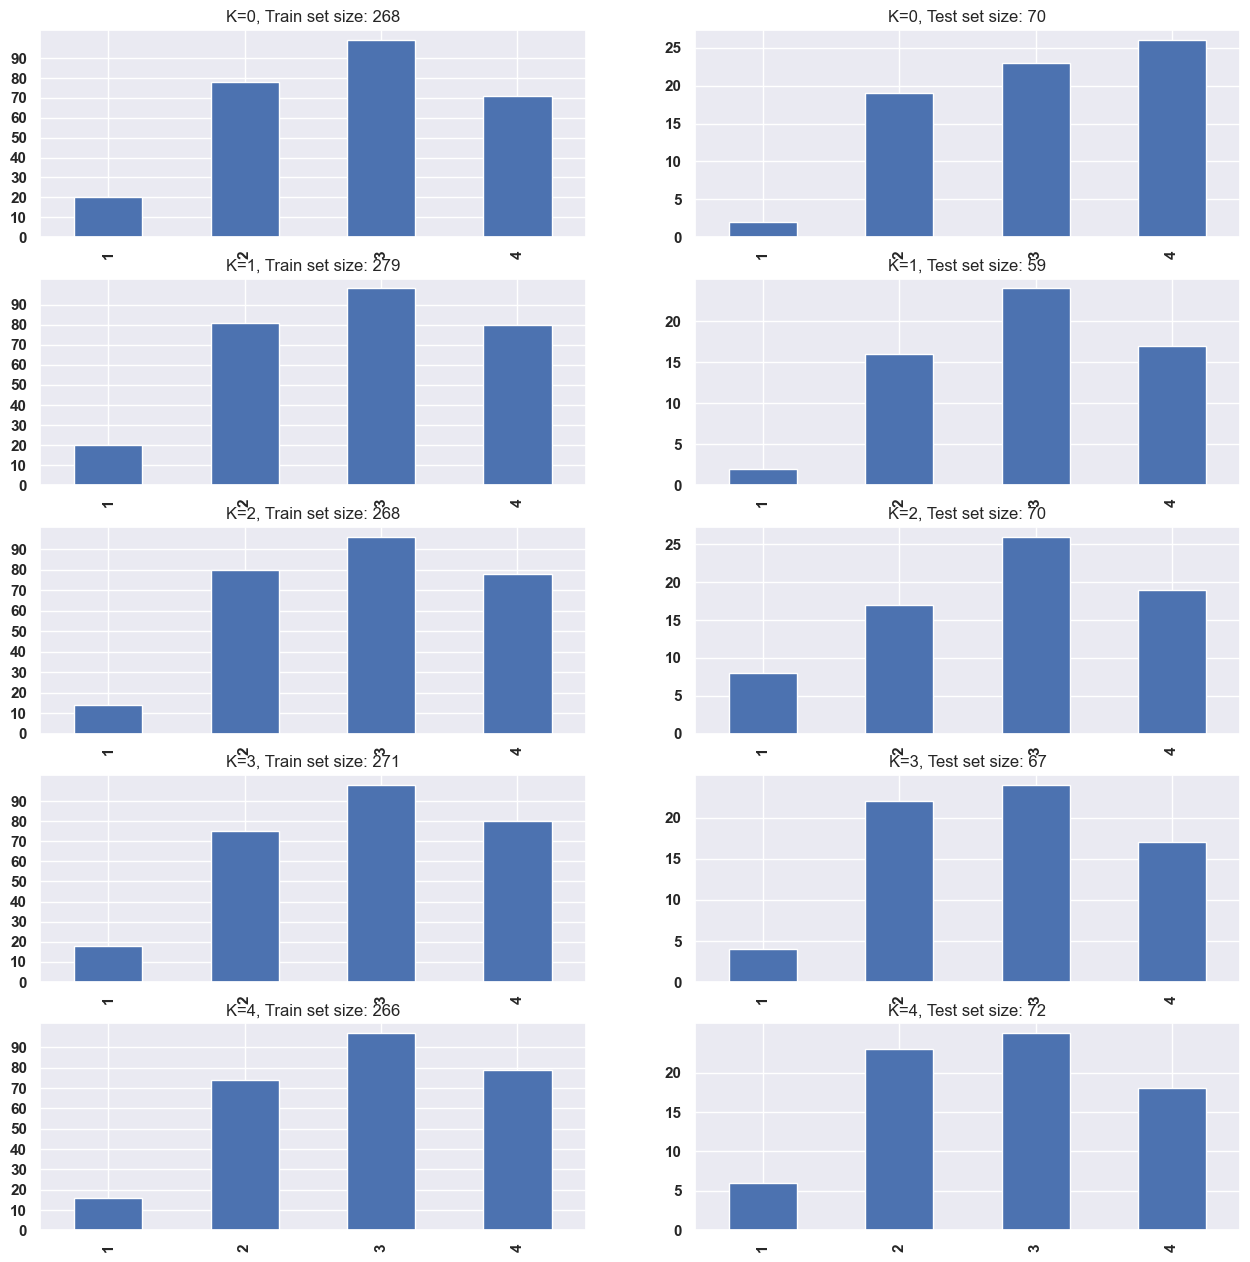

------------------ Level5 ------------------


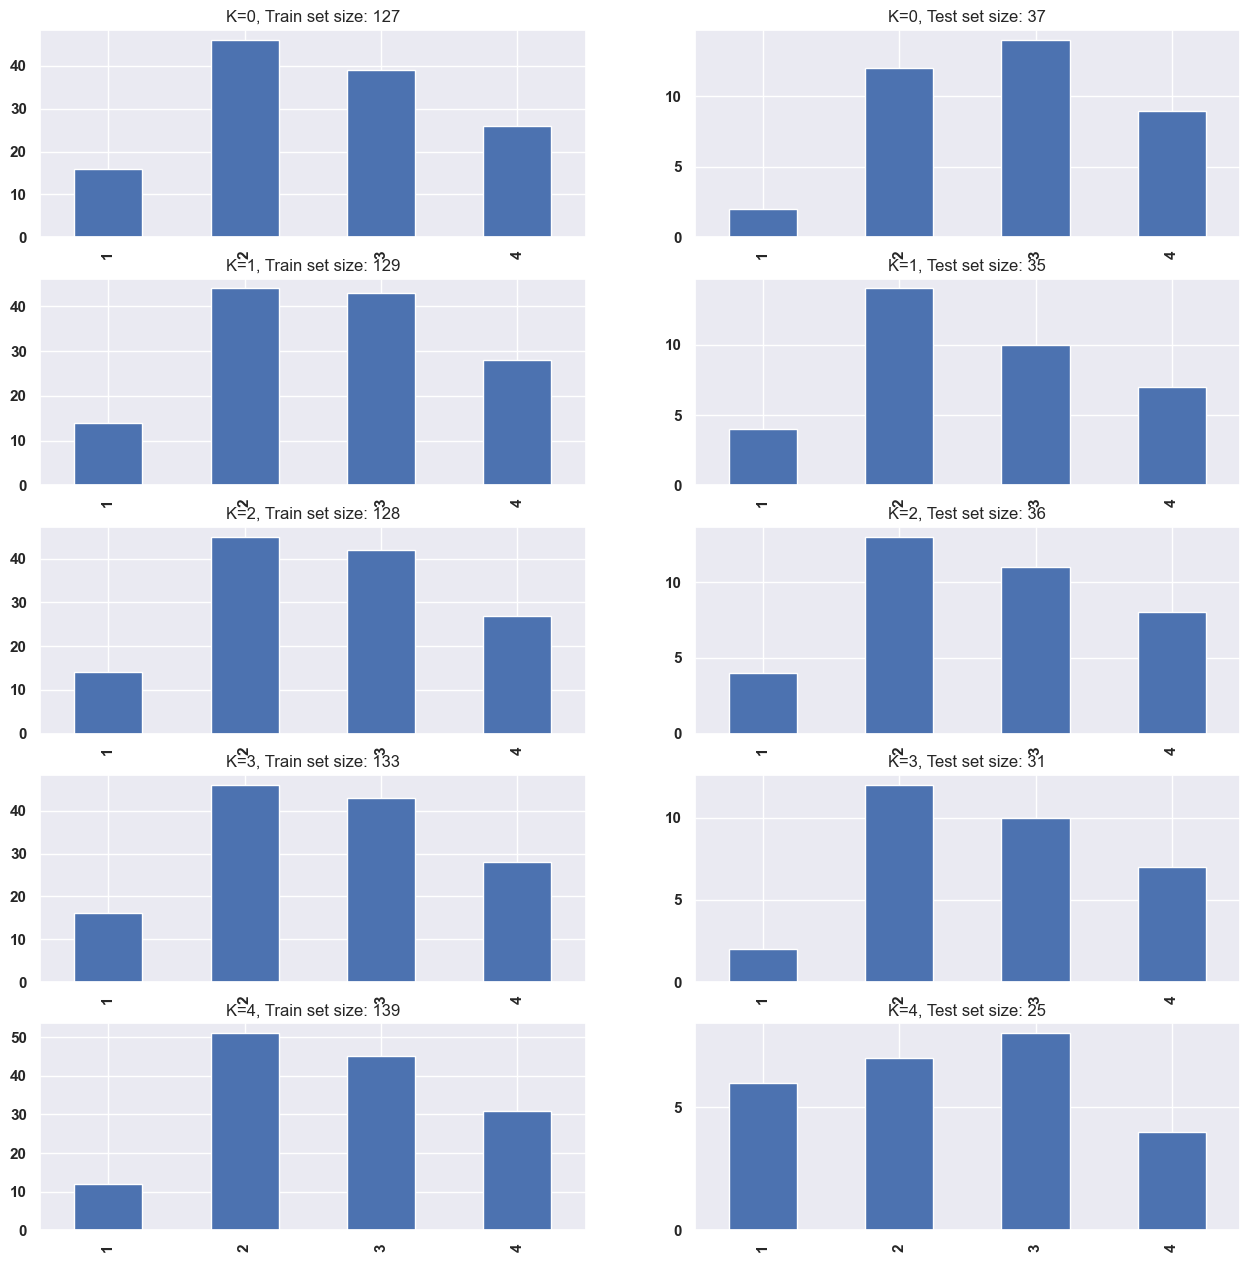

------------------ All_Level ------------------


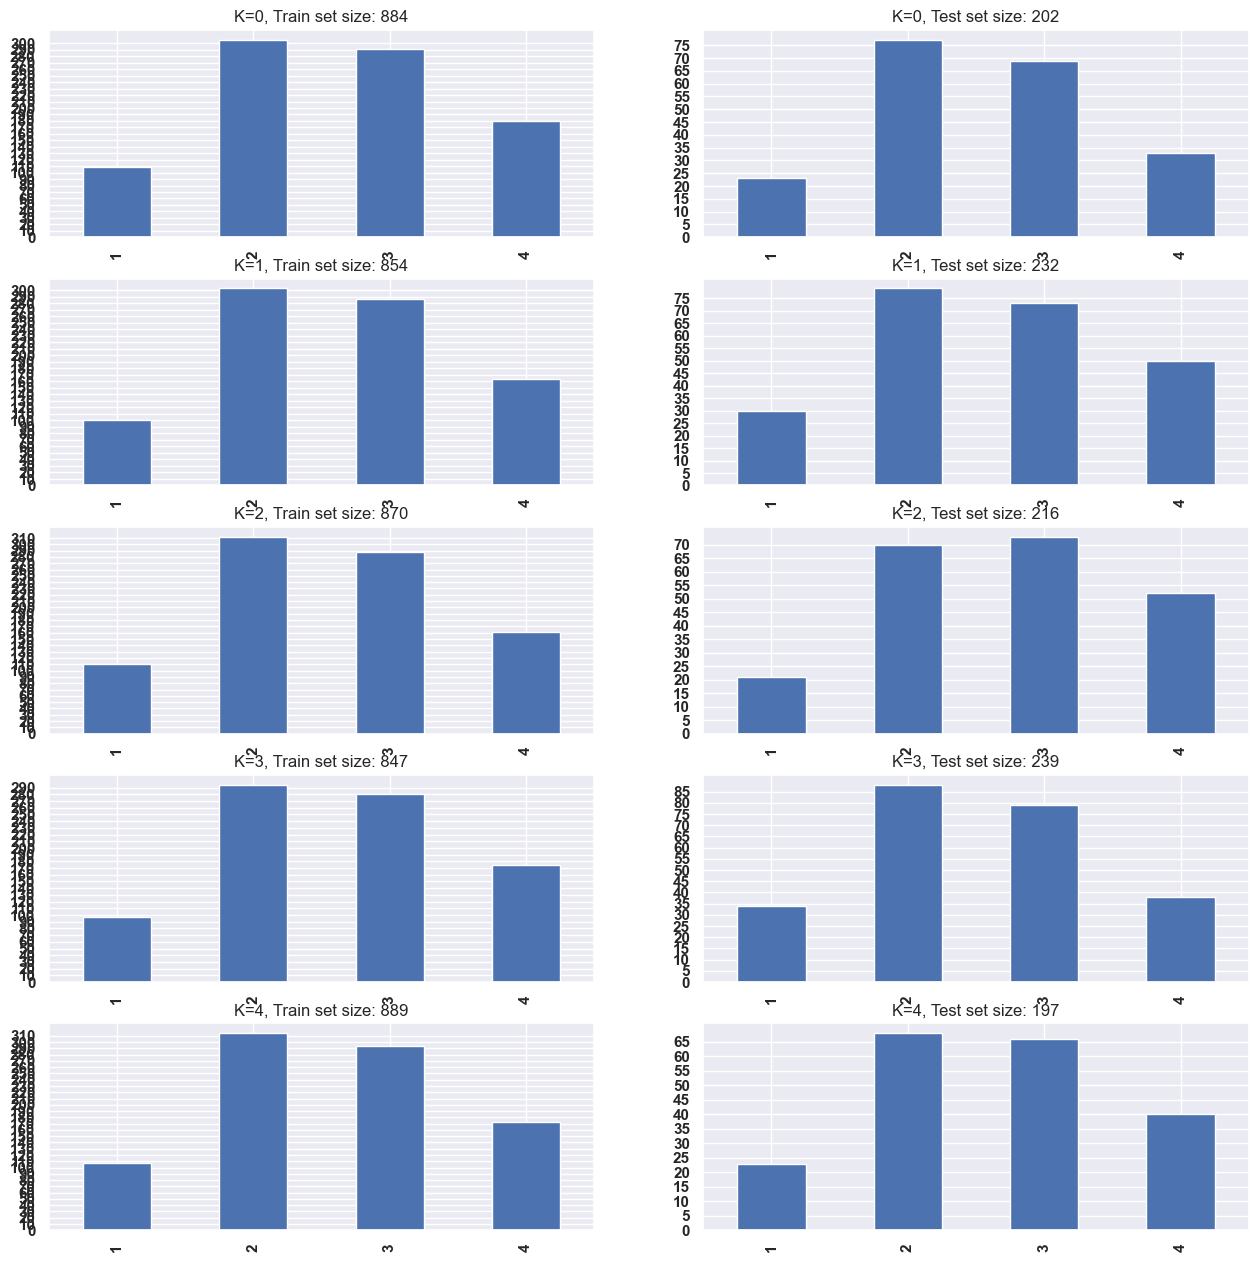

In [127]:
# Show the label distribution per folds
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    fig = plt.figure()
    for k in range(NBFOLDS):
        (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
    
        level_train_set = level_processed_dataframe.iloc[level_train_set_index]
        level_test_set = level_processed_dataframe.iloc[level_test_set_index]

        #  Display class distribution
        train_counts = level_train_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+1)
        ax.title.set_text("K={}, Train set size: {}".format(k, len(level_train_set)))
        train_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(train_counts), 10))
        #plt.show()
        
        test_counts = level_test_set[LABELS_KEY].value_counts(normalize=False).sort_index()
        ax = plt.subplot(NBFOLDS, 2, k*2+2)
        ax.title.set_text("K={}, Test set size: {}".format(k, len(level_test_set)))
        test_counts.plot(kind='bar')
        plt.yticks(np.arange(0, max(test_counts), 5))
        
        """levels_train_sets[level_key]= level_train_set
        levels_test_sets[level_key]= level_test_set"""
    plt.subplots_adjust(bottom=1.5, right=2,top=4)
    plt.show()

### 5.2) Function to split the features and labels

In [128]:
def feature_label_group_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY]) #remove the labels and student_id from the predictors
    dataset_labels = dataset[LABELS_KEY].copy()
    dataset_groups = dataset[STUDENT_ID_KEY].copy()
    return (dataset_features, dataset_labels, dataset_groups)

def feature_label_split(dataset):
    dataset_features = dataset.drop(columns=[LABELS_KEY,STUDENT_ID_KEY])
    dataset_labels = dataset[LABELS_KEY].copy()
    return (dataset_features, dataset_labels)

### 5.3) Functions for feature selections

In [129]:
# Create a custom transformer to delete irrelevant features (all values are the same)
class DeleteIrrelevantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_variance = 1): # no *args or ** kargs
         self.threshold_variance = threshold_variance
            
    def fit(self, X, y = None):
        self.unused_features = []
        for key in X.columns:
            nb_values = X[key].value_counts()
            if len(nb_values) == self.threshold_variance: # If all the values are the same
                # print("Deleted feature :",key)
                self.unused_features.append(key)
        # print("Remain features: ",len(X.columns)-len(self.unused_features))
        return self
    def transform(self, X, y = None):
        # print("Number of deleted features",len(self.unused_features))
        modified_X = X.drop(columns=self.unused_features)    
        return modified_X

In [130]:
# Create a custom transformer to delete highly correlated features
class DeleteCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.9): # no *args or ** kargs
        self.threshold = threshold
        self.to_drop = []
        self.to_keep = []
        
    def fit(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            self.to_drop = [column for column in upper.columns if any(upper[column] >= self.threshold)]
        else:
            corr_matrix = np.absolute(np.corrcoef(X, rowvar=False))
            upper = corr_matrix*np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
            self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X, y = None):
        if isinstance(X, pd.DataFrame):
            X_reduced = X.drop(columns = self.to_drop)
            self.to_keep = X_reduced.columns
        else:
            X_reduced = np.delete(X, self.to_drop, axis=1)
        return X_reduced

In [131]:
# Create a custom transformer to discretize time features (used only for the Naive Bayes Classifier as it does not handles continuous data)
class TimeSpendDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or ** kargs
        pass
    def fit(self, X, y = None):
        self.discretizer = {}
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in X.columns:
                self.discretizer[time_feature] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
                self.discretizer[time_feature].fit(X[[time_feature]])
        return self
    def transform(self, X, y = None):
        modified_X = X.copy()
        for time_feature in TIME_FEATURES_KEYS_TOTAL:
            if time_feature in modified_X.columns:
                modified_X[time_feature] = self.discretizer[time_feature].transform(modified_X[[time_feature]])
        return modified_X


In [132]:
# transformer to normalize the features
data_scaler = MinMaxScaler()

In [133]:
# Create a custom transformer to normalize the features while preserving the DataFrame structure
# Default MinMaxScaler() return a numpy array rather than a panda Dataframe
class DataFrameMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_variance = 1): # no *args or ** kargs
         self.scaler = MinMaxScaler()
            
    def fit(self, X, y = None):
        return self
            
    def transform(self, X, y = None):
        modified_X = self.scaler.fit_transform(X)
        modified_X= pd.DataFrame(modified_X)
        return modified_X

### 5.4) Model evaluation function

evaluate_model(): train and test the models in k-folds cross validation over students, and compute the F1, Precision and Recall.
This is the "simple approach" that trains the models without hyperparameter tuning.

In [134]:
def evaluate_model(pipeline, features, labels, train_groups, scores = ["precision_weighted", "recall_weighted", "f1_weighted"]):
    stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS,shuffle = True, random_state = RAND_STATE_SEED)
    results = cross_validate(pipeline,features,labels,cv=stratified_group_cross_val, scoring = scores, groups=train_groups)
    return results


### 5.5) Pipeline definition for each classifier we consider (based on Sklearn)

We define one pipeline per classifier, and simply save the different pipelines in a list. This means more pipeline can be added (or deleted) as needed.

In [135]:
#Dummy baseline from sklearn
dummy_random_clf_pipe = Pipeline([
    ("dummy_random_clf", DummyClassifier(strategy="uniform"))
])

In [136]:
# Ordered baseline
# This custom baseline is based on the simple approach of delivering the help type in an ordered manner, granted that there is some notions of ordering.
# In our case the help types of ordered based on how much they reveal about the final solutions, from simply reminded the goal of the game level to directly providing the correct solution.

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class OrderedBaseline(BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    # fit model (Nothing to do for the baseline)
    def fit(self, X=None, y=None):
        pass

    # Predict (Escalate help level)
    def predict(self, X):
        res = []
        
        # Check if help received available
        """if all(value in X.columns for value in RECEIVED_HELP_KEYS):
            for ind,row in X.iterrows():
                help_l = [row[RECEIVED_HELP_KEYS[0]], row[RECEIVED_HELP_KEYS[1]], \
                           row[RECEIVED_HELP_KEYS[2]], row[RECEIVED_HELP_KEYS[3]] ]
                help_given_index = [i for i, x in enumerate(help_l) if x > 0]
                if len(help_given_index) == 0: #no help ever given = predict first help
                    res.append(0)
                else: #predict the next help level
                    max_help = max(help_given_index)
                    res.append(min(max_help+1, 3))
        
        # Check if help count available
        el"""
        if REQUESTED_HELP_TOTAL in X.columns:
            for ind,row in X.iterrows():
                if row[REQUESTED_HELP_TOTAL] == 1: #no help ever given before the current one = predict first help
                    res.append(1)
                else: #predict the next help level
                    res.append(int(min(row[REQUESTED_HELP_TOTAL], 4)))
                
        # Otherwise cannot do the prediction
        else:
            res = [-1]*len(X.index)
        return res

#TEST (uncomment and run to test the ordered baseline)
"""for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key:
            print(f"    --------------- {fset_key} ---------------")    
            fset_dataframe = level_processed_dataframe[fset_columns]
            level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe)
            clf = OrderedBaseline()
            clf.fit(level_features, level_labels)
            print(clf.predict(level_features))"""

    

# Important to not remove any features as part of the pipeline as we need to keep the features on previous help received
ordered_clf_pipe = Pipeline([
    ("ordered_baseline_clf", OrderedBaseline())
])



In [137]:
# Teacher Ordered baseline
# This custom baseline is based on the simple approach of delivering the help type in an ordered manner, granted that there is some notions of ordering.
# In our case the help types of ordered based on how much they reveal about the final solutions, from simply reminded the goal of the game level to directly providing the correct solution.

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class TeacherOrderedBaseline(BaseEstimator):
    def __init__(self, random_state=None):
        self.random_state = random_state

    # fit model (Nothing to do for the baseline)
    def fit(self, X=None, y=None):
        pass

    # Predict (Escalate help level)
    def predict(self, X):
        res = []
        
        # Check if help received available
        """if all(value in X.columns for value in RECEIVED_HELP_KEYS):
            for ind,row in X.iterrows():
                help_l = [row[RECEIVED_HELP_KEYS[0]], row[RECEIVED_HELP_KEYS[1]], \
                           row[RECEIVED_HELP_KEYS[2]], row[RECEIVED_HELP_KEYS[3]] ]
                help_given_index = [i for i, x in enumerate(help_l) if x > 0]
                if len(help_given_index) == 0: #no help ever given = predict first help
                    res.append(1)
                else: #predict the next help level
                    max_help = max(help_given_index)
                    res.append(min(max_help+1, 3))
        
        # Check if help count available
        el"""
        if REQUESTED_HELP_TOTAL in X.columns:
            for ind,row in X.iterrows():
                if row[REQUESTED_HELP_TOTAL] == 1: #no help ever given before the current one = predict most likely starting help given by teachers
                    res.append(2)
                else: #predict most likely next help given by teachers
                    res.append(int(min(row[REQUESTED_HELP_TOTAL]+1, 4)))
                
        # Otherwise cannot do the prediction
        else:
            res = [-1]*len(X.index)
        return res

#TEST (uncomment and run to test the teacher baseline)
"""for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key:
            print(f"    --------------- {fset_key} ---------------")    
            fset_dataframe = level_processed_dataframe[fset_columns]
            level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe)
            clf = TeacherOrderedBaseline()
            clf.fit(level_features, level_labels)
            #print(level_processed_dataframe[ ["game_id", "help_type"]])
            print(clf.predict(level_features))
"""
    

# Important to not remove any features as part of the pipeline as we need to keep the features on previous help received
teacher_ordered_clf_pipe = Pipeline([
    ("teacher_order_baseline_clf", TeacherOrderedBaseline())
])



In [138]:
# Multinomial Naive Bayes classifier

naive_bayes_clf_pipe = Pipeline([
    ("time_spend_discretizer",TimeSpendDiscretizer()),
    ("feature_deleter",DeleteIrrelevantFeatures()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("naive_bayes_clf", MultinomialNB())
])

In [139]:
# Logistic regression

logistic_regression_clf_pipe = Pipeline([
    ("feature_deleter",DeleteIrrelevantFeatures()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("logistic_regression_clf", LogisticRegression(max_iter=200,random_state=RAND_STATE_SEED))
])

In [140]:
# SVM

svm_clf_pipe = Pipeline([
    ("feature_deleter",DeleteIrrelevantFeatures()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("svm_gaussian_clf", SVC(kernel="rbf"))
])

In [141]:
# Decision tree

decision_tree_clf_pipe = Pipeline([
    ("feature_deleter",DeleteIrrelevantFeatures()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("decision_tree_clf", DecisionTreeClassifier(random_state = RAND_STATE_SEED))
])

In [142]:
#Random Forests

random_forest_clf_pipe = Pipeline([
    ("feature_deleter",DeleteIrrelevantFeatures()),#VarianceThreshold()),
    ("features_correlated",DeleteCorrelatedFeatures(CORREL_THRESHOLD)),
    ("data_scaler", MinMaxScaler()),
    ("random_forest_clf", RandomForestClassifier(random_state = RAND_STATE_SEED))
])

In [143]:
#Crate the final list of all classifiers
classifiers = {
    "Dummy random baseline": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Teacher ordered baseline": teacher_ordered_clf_pipe,
    "Naive Bayes": naive_bayes_clf_pipe,
    "Logistic regression":logistic_regression_clf_pipe,
    "SVM": svm_clf_pipe,
    "Decision Tree":decision_tree_clf_pipe,
    "Random Forest": random_forest_clf_pipe
}

## 6) Model training and evaluation (no hyper-parameter tuning)

Here we first train and evaluate the models using the default values in Sklearn for the hyperparameters of the models.
We compute the F1 score, precision and recall using the evaluate_model() function in stratified k-folds cross validation over students (k=NBFOLDS).

In [144]:
#for debug
levels_processed_dataframes["Level1"][FEATURES_SETS["mean_rate_features_nohelp_nosub"]].to_csv("inspect_features_lvl1.csv")

In [145]:
metrics = [
    "Precision_m",
    "Precision_std",
    "Recall_m",
    "Recall_std",
    "F1_score_m",
    "F1_score_std"
]

if SMOTE_MINORITY: # Oversample minority classes with SMOTE
    smoter = SMOTE(random_state=RAND_STATE_SEED)

fold_results = []

# Iterate over the game levels, feature sets and folds to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")         
    for fset_key, fset_columns in FEATURES_SETS.items():  
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        
        print(f"    --------------- {fset_key} ---------------") 
            
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups = feature_label_group_split(fset_dataframe)
        baseline_dataframe = level_processed_dataframe[ FEATURES_SETS[BASELINE_FEATURE_SET] ]
        baseline_level_features, baseline_level_labels, baseline_level_groups = feature_label_group_split(baseline_dataframe)
        #print(level_features.describe())
        
        if SMOTE_MINORITY: # Oversample minority classes, in the train sets ONLY
            (level_features, level_labels) = smoter.fit_resample(level_features, level_labels)
            level_train_set_groups = range(0, len(level_labels)) # Within-train-set groups make no sense anymore with SMOTE
                
        
        for classifier_name, classifier in classifiers.items():
            if "baseline" in classifier_name: # Feed baseline feature set instead
                cv_results = evaluate_model(classifier, baseline_level_features, baseline_level_labels, baseline_level_groups)
                for k in range(NBFOLDS):
                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key, #just for output
                        "K": k,
                        "classifier": classifier_name,
                        "Precision":cv_results["test_precision_weighted"][k],
                        "Recall":cv_results["test_recall_weighted"][k],
                        "F1_score":cv_results["test_f1_weighted"][k]
                    })
            else:
                cv_results = evaluate_model(classifier, level_features, level_labels, level_groups)
                for k in range(NBFOLDS):
                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "Precision":cv_results["test_precision_weighted"][k],
                        "Recall":cv_results["test_recall_weighted"][k],
                        "F1_score":cv_results["test_f1_weighted"][k]
                    })


levels_results = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- mean_sd_rate_features_nohelp_nosub ---------------
    --------------- mean_rate_features_nohelp_nosub ---------------
    --------------- mean_sd_rate_ib_no_sub_content_features_keys ---------------
    --------------- mean_sd_rate_oa_features_keys ---------------
    --------------- mean_rate_ib_no_sub_content_features_keys ---------------
    --------------- mean_rate_oa_features_keys ---------------
------------------ Level3 ------------------
    --------------- mean_sd_rate_features_nohelp_nosub ---------------
    --------------- mean_rate_features_nohelp_nosub ---------------
    --------------- mean_sd_rate_ib_no_sub_content_features_keys ---------------
    --------------- mean_sd_rate_oa_features_keys ---------------
    --------------- mean_rate_ib_no_sub_content_features_keys ---------------
    --------------- mean_rate_oa_features_keys ---------------
------------------ Level4 ------------------
    -------

In [146]:
#print results
pd.pivot_table(levels_results.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

F1_score  \
level_key features_set                                 classifier                           
All_Level mean_rate_features_nohelp_nosub              Decision Tree             0.497402   
                                                       Dummy random baseline     0.261422   
                                                       Logistic regression       0.526675   
                                                       Naive Bayes               0.439759   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.602672   
                                                       SVM                       0.547889   
                                                       Teacher ordered baseline  0.476816   
          mean_rate_ib_no_sub_content_features_keys    Decision Tree             0.417036   
                                                       Dummy random baseline     0.264259   
                                                       Logistic regression       0.375242   
                                                       Naive Bayes               0.362673   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.474446   
                                                       SVM                       0.391117   
                                                       Teacher ordered baseline  0.476816   
          mean_rate_oa_features_keys                   Decision Tree             0.446669   
                                                       Dummy random baseline     0.282082   
                                                       Logistic regression       0.483918   
                                                       Naive Bayes               0.407737   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.524062   
                                                       SVM                       0.503353   
                                                       Teacher ordered baseline  0.476816   
          mean_sd_rate_features_nohelp_nosub           Decision Tree             0.489119   
                                                       Dummy random baseline     0.244258   
                                                       Logistic regression       0.551530   
                                                       Naive Bayes               0.454193   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.605857   
                                                       SVM                       0.550853   
                                                       Teacher ordered baseline  0.476816   
          mean_sd_rate_ib_no_sub_content_features_keys Decision Tree             0.404461   
                                                       Dummy random baseline     0.261994   
                                                       Logistic regression       0.401412   
                                                       Naive Bayes               0.356599   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.482381   
                                                       SVM                       0.390589   
                                                       Teacher ordered baseline  0.476816   
          mean_sd_rate_oa_features_keys                Decision Tree             0.448689   
                                                       Dummy random baseline     0

## 7) Model training and evaluation with hyper-parameter tuning

We repeat the process of 6) but this time with hyper-parameter tuning, using the GridSearch mechanism from Sklearn. This means we use stratified nested cross-validation over students, with the grid search applied at the inner loop of the nested cross validation.

Notice that we have defined a small and a large grid for each hyperparameter (cf. code below), but we typically use the small one.

In [147]:
levels_results_grid = {}

#this is for the inner level of the nested cross-validation
stratified_group_cross_val = StratifiedGroupKFold(n_splits=NBFOLDS_GRID, shuffle = True, random_state = RAND_STATE_SEED)

#define the grid for each model
param_grid_nb = [{
    # Default value in sklearn: 1.0
    #'naive_bayes_clf__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001] #large grid
    #'naive_bayes_clf__alpha': [10.0, 1.0, 0.1] #small grid
    'naive_bayes_clf__alpha': [1.0] #no grid
}]

param_grid_lr = [{
    # Default value in sklearn: 1.0
    #'logistic_regression_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    #'logistic_regression_clf__C': [10.0, 1.0, 0.1], #small grid
    'logistic_regression_clf__C': [1.0], #no grid
    # Default: 100
    'logistic_regression_clf__max_iter': [200] #to converge
}]

param_grid_svm = [{
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__C': [100.0, 50.0, 25.0, 10.0, 5.0, 1.0, 0.5, 0.1], #large grid
    #'svm_gaussian_clf__C': [10.0, 1.0, 0.1], #small grid
    'svm_gaussian_clf__C': [1.0], #nogrid
    # Default value in sklearn: 1.0
    #'svm_gaussian_clf__gamma': [10, 1.0, 0.5, 0.1, 0.01, 0.001, 0.0001], #large grid
    #'svm_gaussian_clf__gamma': [10.0, 1.0, 0.1], #small grid
    'svm_gaussian_clf__gamma': [1.0], #no grid
    # Default value in sklearn: rbf
    #'svm_gaussian_clf__kernel': ['rbf', 'poly', 'sigmoid'] #large+small grid
    'svm_gaussian_clf__kernel': ['rbf'] #no grid
}]

        
param_grid_rf = [{
    # Default value in sklearn: 100
    #"random_forest_clf__n_estimators": [20, 50, 100, 200, 500], #large grid
    #"random_forest_clf__n_estimators": [50, 100, 200], #small grid
    "random_forest_clf__n_estimators": [100], #no grid
    # Default value in sklearn: None
    #"random_forest_clf__max_depth" : [4,6,8,10,12,14,16,18,None],    #large grid
    #"random_forest_clf__max_depth" : [6,12,None],    #small grid
    "random_forest_clf__max_depth" : [None],    #no grid
}]


#add all of the grids in a dict
grids = {
    
    "Dummy random baseline": dummy_random_clf_pipe,
    "Ordered baseline": ordered_clf_pipe,
    "Teacher Ordered baseline": teacher_ordered_clf_pipe,
    "Naive Bayes": GridSearchCV( 
                                estimator = naive_bayes_clf_pipe,
                                param_grid = param_grid_nb,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Logistic regression": GridSearchCV( 
                                estimator = logistic_regression_clf_pipe,
                                param_grid = param_grid_lr,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "SVM": GridSearchCV( 
                                estimator = svm_clf_pipe,
                                param_grid = param_grid_svm,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1),
    "Random Forest": GridSearchCV( 
                                estimator = random_forest_clf_pipe,
                                param_grid = param_grid_rf,
                                cv = stratified_group_cross_val,
                                verbose = 1,
                                scoring ='f1_weighted',
                                n_jobs=-1)
}


if SMOTE_MINORITY: # Oversample minority classes with SMOTE
    smoter = SMOTE(random_state=RAND_STATE_SEED)
        
fold_results = []
pred_results = {}
pred_labels = {}
levels_grid_classifier = {}

# Iterate over the game level, feature sets and fold to train the models
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    pred_results[level_key] = {}
    pred_labels[level_key] = {}
    levels_grid_classifier[level_key] = {}
       
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        print(f"    --------------- {fset_key} ---------------")
        pred_results[level_key][fset_key] = {}
        pred_labels[level_key][fset_key] = {}
        levels_grid_classifier[level_key][fset_key] = {}
        
        # Keep only features relevant to the current features sets
        fset_dataframe = level_processed_dataframe[fset_columns]
        baseline_dataframe = level_processed_dataframe[ FEATURES_SETS[BASELINE_FEATURE_SET] ]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]
            baseline_train_set = baseline_dataframe.iloc[level_train_set_index]
            baseline_test_set = baseline_dataframe.iloc[level_test_set_index]
            
            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)
            
            baseline_train_set_features, baseline_train_set_labels, baseline_train_set_groups  = feature_label_group_split(baseline_train_set)
            baseline_test_set_features, baseline_test_set_labels  = feature_label_split(baseline_test_set)

            if SMOTE_MINORITY: # Oversample minority classes, in the train sets ONLY
                (level_train_set_features, level_train_set_labels) = smoter.fit_resample(level_train_set_features, level_train_set_labels)
                level_train_set_groups = range(0, len(level_train_set_labels)) # Within-train-set groups make no sense anymore with SMOTE
                
            for classifier_name, grid_pipeline in grids.items():
                if classifier_name not in pred_results[level_key][fset_key]: pred_results[level_key][fset_key][classifier_name] = [] 
                if classifier_name not in pred_labels[level_key][fset_key]: pred_labels[level_key][fset_key][classifier_name] = []
                if classifier_name not in levels_grid_classifier[level_key][fset_key]: levels_grid_classifier[level_key][fset_key][classifier_name] = []

                if "baseline" in classifier_name: # No grid search for the baselines
                    grid_pipeline.fit(baseline_train_set_features,baseline_train_set_labels)
                    grid_predictions = grid_pipeline.predict(baseline_test_set_features)
                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": "",
                        "grid_params": "",
                        "precision": precision_score(baseline_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(baseline_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(baseline_test_set_labels, grid_predictions, average='weighted')
                    })
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(baseline_test_set_labels)  
                else:
                    grid_pipeline.fit(level_train_set_features,y=level_train_set_labels, groups=level_train_set_groups)
                    grid_predictions = grid_pipeline.predict(level_test_set_features)
                    print(classifier_name)
                    print(f"--Best score: {f1_score(level_test_set_labels, grid_predictions, average='weighted')}")
                    print("--Best params: ",grid_pipeline.best_params_)

                    fold_results.append({
                        "level_key": level_key,
                        "features_set": fset_key,
                        "K": k,
                        "classifier": classifier_name,
                        "grid_F1": grid_pipeline.best_score_,
                        "grid_params" : str(grid_pipeline.best_params_),
                        "precision": precision_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "recall": recall_score(level_test_set_labels, grid_predictions, average='weighted'),
                        "f1_score":f1_score(level_test_set_labels, grid_predictions, average='weighted')
                    })
                    
                    '''prints for debug:
                    print(grid_pipeline.best_estimator_['data_scaler'].n_features_in_)
                    print(grid_pipeline.best_estimator_['features_correlated'].to_drop)
                    print(len(level_train_set_features.columns))
                    print(grid_pipeline.best_estimator_['random_forest_clf'].feature_importances_)
                    print(grid_pipeline.best_estimator_)
                    #print(grid_pipeline.best_estimator_["feature_deleter"].feature_names_in_)
                    print(grid_pipeline.best_estimator_["features_correlated"].to_keep)'''
                    
                    levels_grid_classifier[level_key][fset_key][classifier_name].append(deepcopy(grid_pipeline.best_estimator_))
                    pred_results[level_key][fset_key][classifier_name] += list(grid_predictions)
                    pred_labels[level_key][fset_key][classifier_name] += list(level_test_set_labels)

levels_results_grid = pd.DataFrame.from_records(fold_results) 
print("Done")

------------------ Level1 ------------------
    --------------- mean_sd_rate_features_nohelp_nosub ---------------
------------------ 0 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.4934640522875817
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.4896043771043771
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.4691919191919192
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.5686123911930363
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candida

SVM
--Best score: 0.4978123480797278
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.4414472220796332
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.38199165175909366
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.5841073271413829
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.701764705882353
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, to

Random Forest
--Best score: 0.49146005509641877
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3181818181818182
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.574660633484163
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.6793650793650793
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.7353535353535354
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 f

Random Forest
--Best score: 0.46212594176395083
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.4279729094696201
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.5971222606074823
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.5877591023130929
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.6299709610564874
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 

Random Forest
--Best score: 0.39992229992229994
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.37891967835470663
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.4276890550740844
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.4052536677321531
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.5096588596588596
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5

Random Forest
--Best score: 0.46477183752196166
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3878509351595979
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.40008190008190003
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.3962713765068685
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.4685957716419901
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5

Random Forest
--Best score: 0.6994290023701788
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.5020687311499087
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.5881086898036051
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.5516237219515543
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.6954734252839937
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 f

Random Forest
--Best score: 0.5622857142857143
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3520370565322666
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.427855954682372
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.4192814004619967
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.48289094979213304
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 f

Random Forest
--Best score: 0.5333968253968253
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3095450490633363
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.47318557149065626
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.4127220524219691
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.5223462617074884
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 

Random Forest
--Best score: 0.6312855654843484
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.43404761904761907
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.5547329736492299
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.46883295915553985
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.6323076923076922
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5

Random Forest
--Best score: 0.47699690922197313
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.38617511520737324
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.41792717086834735
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.3752605042016807
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.4679365079365079
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 

Random Forest
--Best score: 0.4731304731304731
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3620370370370371
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.2953383458646617
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.3058275058275058
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.5620703933747412
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 f

Random Forest
--Best score: 0.6330486561691963
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.4378579963465875
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.5359122158181854
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.5733193471211606
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.5875009976977398
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 f

Random Forest
--Best score: 0.5243828681510685
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.35129013079667065
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.3536559930266896
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.34661903195627675
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.424230297423681
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 

Random Forest
--Best score: 0.4786258888066142
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 1 ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes
--Best score: 0.3615529488374316
--Best params:  {'naive_bayes_clf__alpha': 1.0}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic regression
--Best score: 0.3083622490139484
--Best params:  {'logistic_regression_clf__C': 1.0, 'logistic_regression_clf__max_iter': 200}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
SVM
--Best score: 0.3332262518802523
--Best params:  {'svm_gaussian_clf__C': 1.0, 'svm_gaussian_clf__gamma': 1.0, 'svm_gaussian_clf__kernel': 'rbf'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Random Forest
--Best score: 0.45857738179033447
--Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}
------------------ 2 ------------------
Fitting 5 

In [148]:
#display results
pd.pivot_table(levels_results_grid.drop("K", axis=1), index=['level_key','features_set','classifier'], aggfunc='mean')

f1_score  \
level_key features_set                                 classifier                           
All_Level mean_rate_features_nohelp_nosub              Dummy random baseline     0.243639   
                                                       Logistic regression       0.526675   
                                                       Naive Bayes               0.439759   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.602672   
                                                       SVM                       0.548757   
                                                       Teacher Ordered baseline  0.476816   
          mean_rate_ib_no_sub_content_features_keys    Dummy random baseline     0.237067   
                                                       Logistic regression       0.375242   
                                                       Naive Bayes               0.362673   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.474446   
                                                       SVM                       0.373349   
                                                       Teacher Ordered baseline  0.476816   
          mean_rate_oa_features_keys                   Dummy random baseline     0.270606   
                                                       Logistic regression       0.483918   
                                                       Naive Bayes               0.407737   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.524062   
                                                       SVM                       0.489236   
                                                       Teacher Ordered baseline  0.476816   
          mean_sd_rate_features_nohelp_nosub           Dummy random baseline     0.263160   
                                                       Logistic regression       0.551530   
                                                       Naive Bayes               0.454193   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.605857   
                                                       SVM                       0.557895   
                                                       Teacher Ordered baseline  0.476816   
          mean_sd_rate_ib_no_sub_content_features_keys Dummy random baseline     0.274572   
                                                       Logistic regression       0.401412   
                                                       Naive Bayes               0.356599   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.482381   
                                                       SVM                       0.385606   
                                                       Teacher Ordered baseline  0.476816   
          mean_sd_rate_oa_features_keys                Dummy random baseline     0.234273   
                                                       Logistic regression       0.502119   
                                                       Naive Bayes               0.415351   
                                                       Ordered baseline          0.261790   
                                                       Random Forest             0.530762   
                                                       SVM                       0.517462   
                                                       Teacher Ordered baseline  0

## 8) Display model performance

In [149]:
levels_results_grid_stats = {}
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    means = subres.groupby(['classifier'], as_index=True, sort=False).mean()
    means = means.add_suffix("_avg")
    
    subres = levels_results_grid[levels_results_grid["level_key"] == level_key].drop(["level_key","K"], axis=1)
    stds = subres.groupby(['classifier'], as_index=True, sort=False).std()
    stds = stds.add_suffix("_std")
    
    levels_results_grid_stats[level_key] = pd.concat([means, stds], axis=1, join='inner')

------------------ Level1 ------------------
------------------ Level3 ------------------
------------------ Level4 ------------------
------------------ Level5 ------------------
------------------ All_Level ------------------


------------------ Level1 ------------------
Best classifier : Random Forest, F1_score : 0.6429978274986564
------------------ Level3 ------------------
Best classifier : Random Forest, F1_score : 0.5075471514404708
------------------ Level4 ------------------
Best classifier : Random Forest, F1_score : 0.5857203887991494
------------------ Level5 ------------------
Best classifier : Random Forest, F1_score : 0.4944729914180726
------------------ All_Level ------------------
Best classifier : Random Forest, F1_score : 0.536696520165317


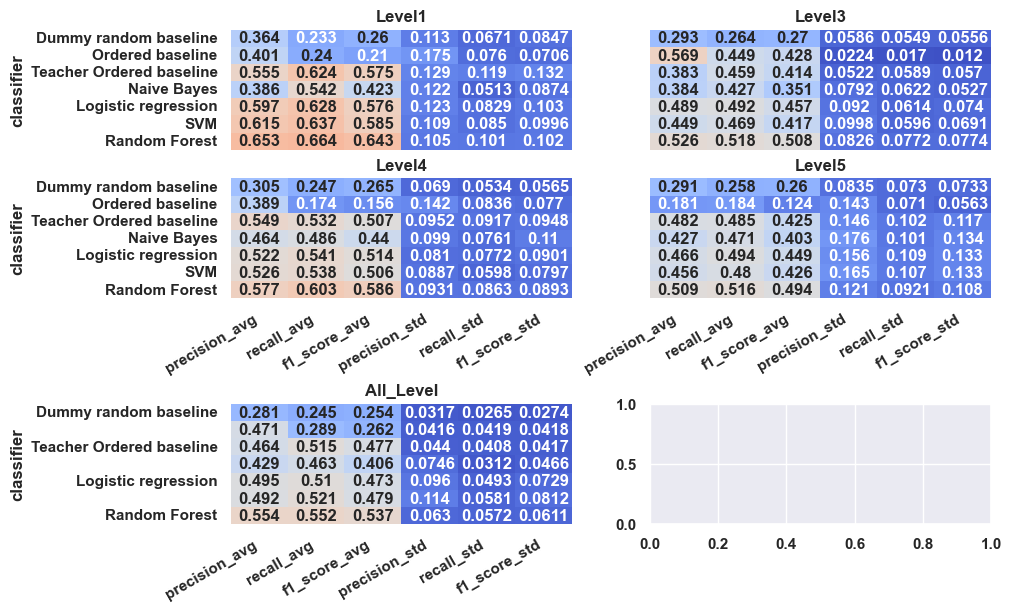

In [150]:
levels_best_classifier_score = {}

fig, axs = plt.subplots(3,2, constrained_layout=True,figsize=[10,6])
index = 0
FSCORE_INDEX = 2
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
      
    col = index % 2
    row = index // 2
    cbar = False
    if col == 2:
        cbar= True
    sns.heatmap(levels_results_grid_stats[level_key], ax = axs[row,col], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=cbar)
    axs[row,col].set_title(level_key,fontweight='bold')
    if row == 0 :
        axs[row,col].get_xaxis().set_visible(False)
    else :     
        for label in axs[row,col].get_xticklabels():
            label.set_ha("right")
            label.set_rotation(30)
    if col !=0 :
        axs[row,col].get_yaxis().set_visible(False)
    
    best_classifier = levels_results_grid_stats[level_key].sort_values(by=["f1_score_avg"], ascending=False).iloc[0]
    levels_best_classifier_score[level_key] = best_classifier[FSCORE_INDEX]
    print(f"Best classifier : {best_classifier.name}, F1_score : {best_classifier[FSCORE_INDEX]}")
    index += 1
plt.savefig(f"outputdata/Pyrates_performancetable_hypertuning_{EXPORT_SUFFIX}.png")
plt.show()

## 9) Compute confusion matrices

**From this point onward we focus on examining the best classifier only (i.e., the one that yield the best performances).**

In [151]:
#in our case the best classifier is Random Forest
best_classifier = "Random Forest"
best_classifier_pipeline = "random_forest_clf"
target_names = ["TR", "CO", "PI", "CR"]

Confusion matrices are generated both in a normalized way (proportion of correct prediction), and in a absolute way (total number of correct predictions).

------------------ Normalized Matrices ------------------
------------------ Level1  ------------------


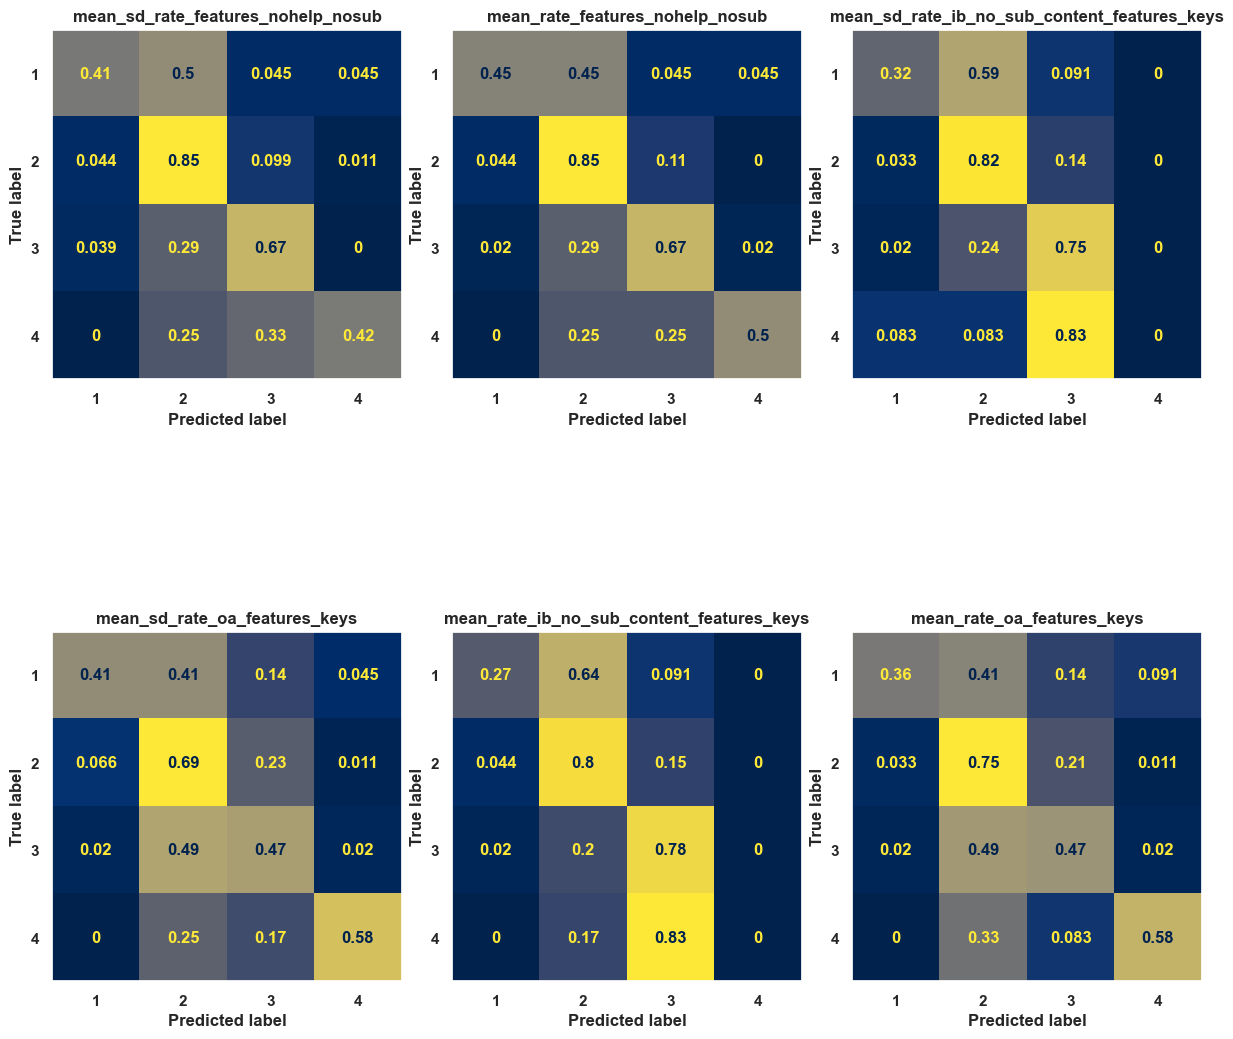

------------------ Level3  ------------------


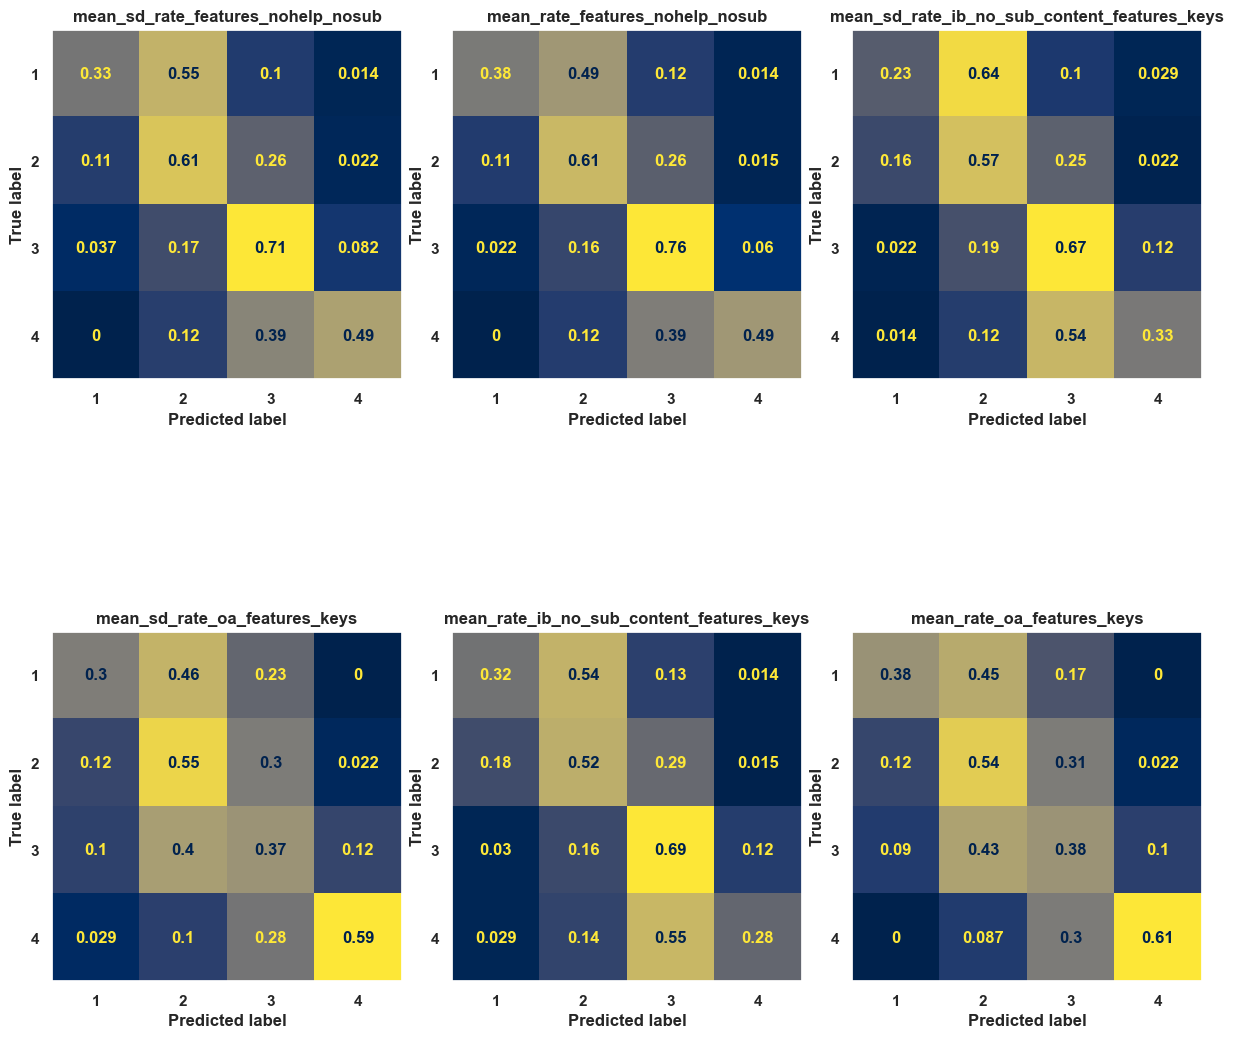

------------------ Level4  ------------------


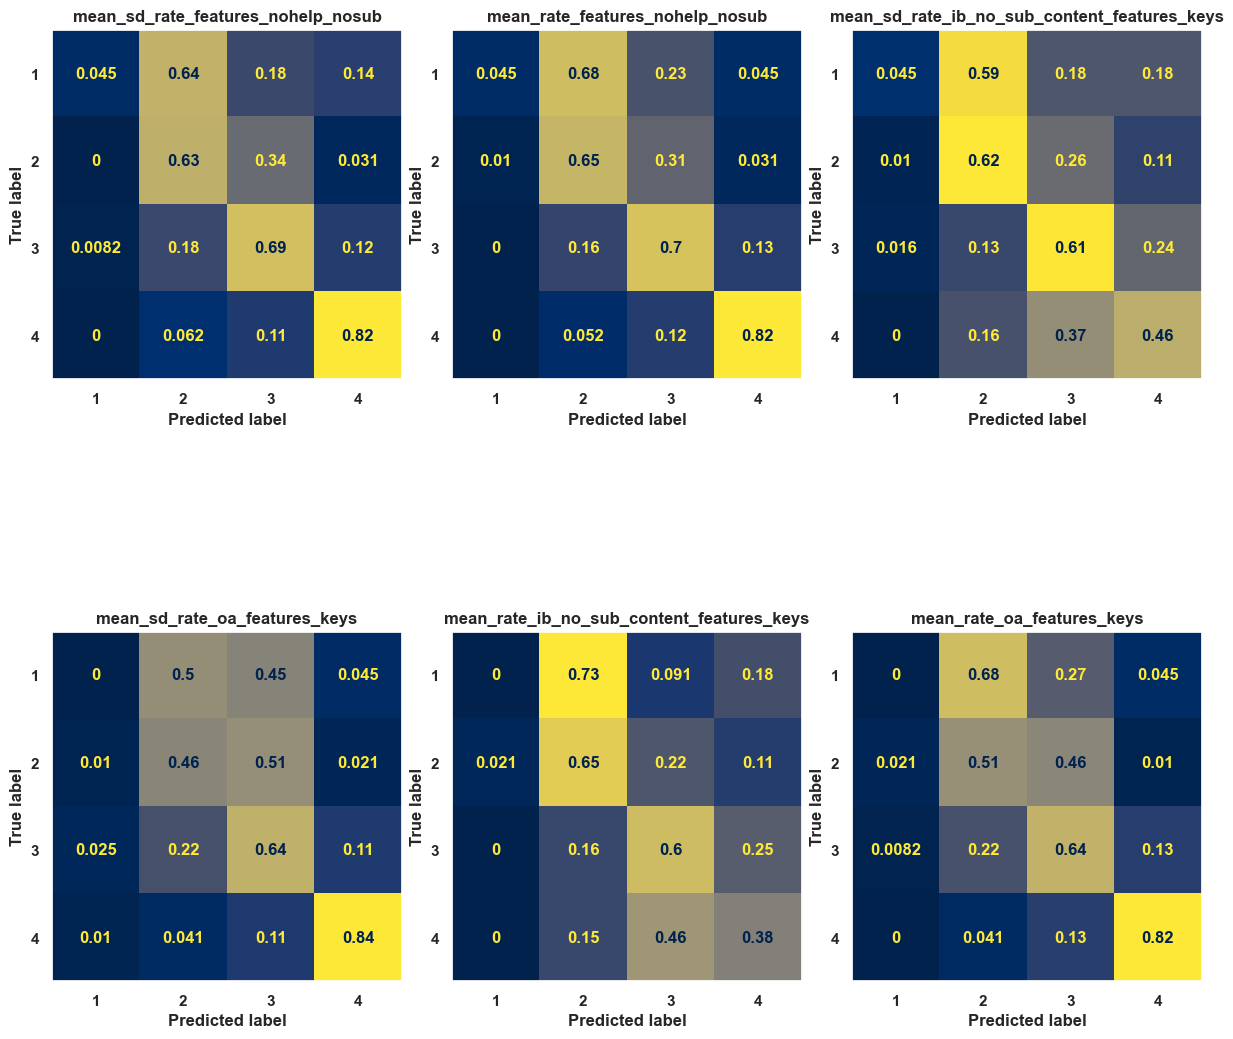

------------------ Level5  ------------------


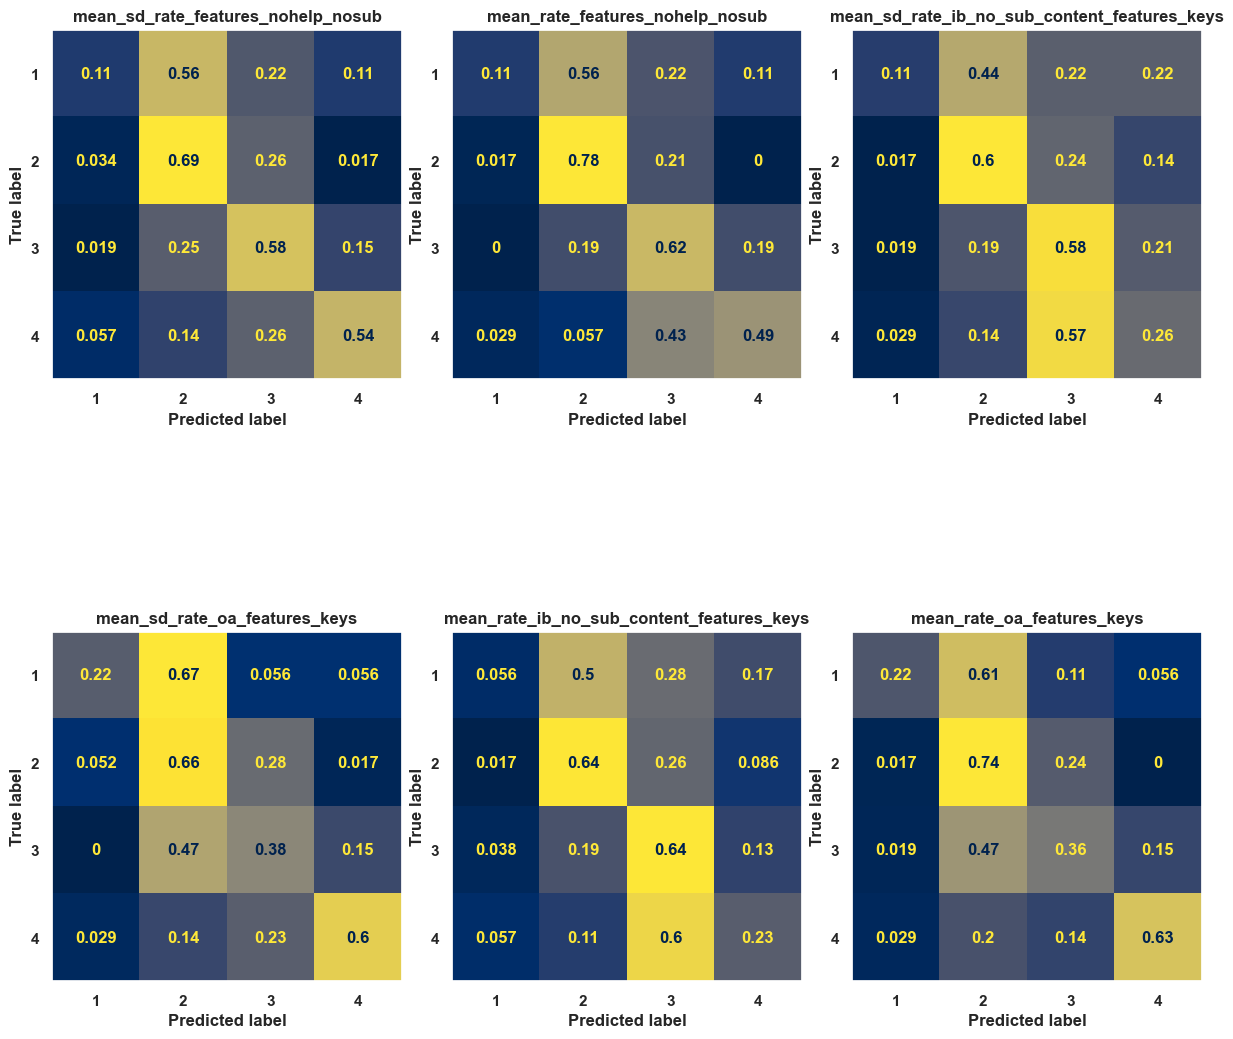

------------------ All_Level  ------------------


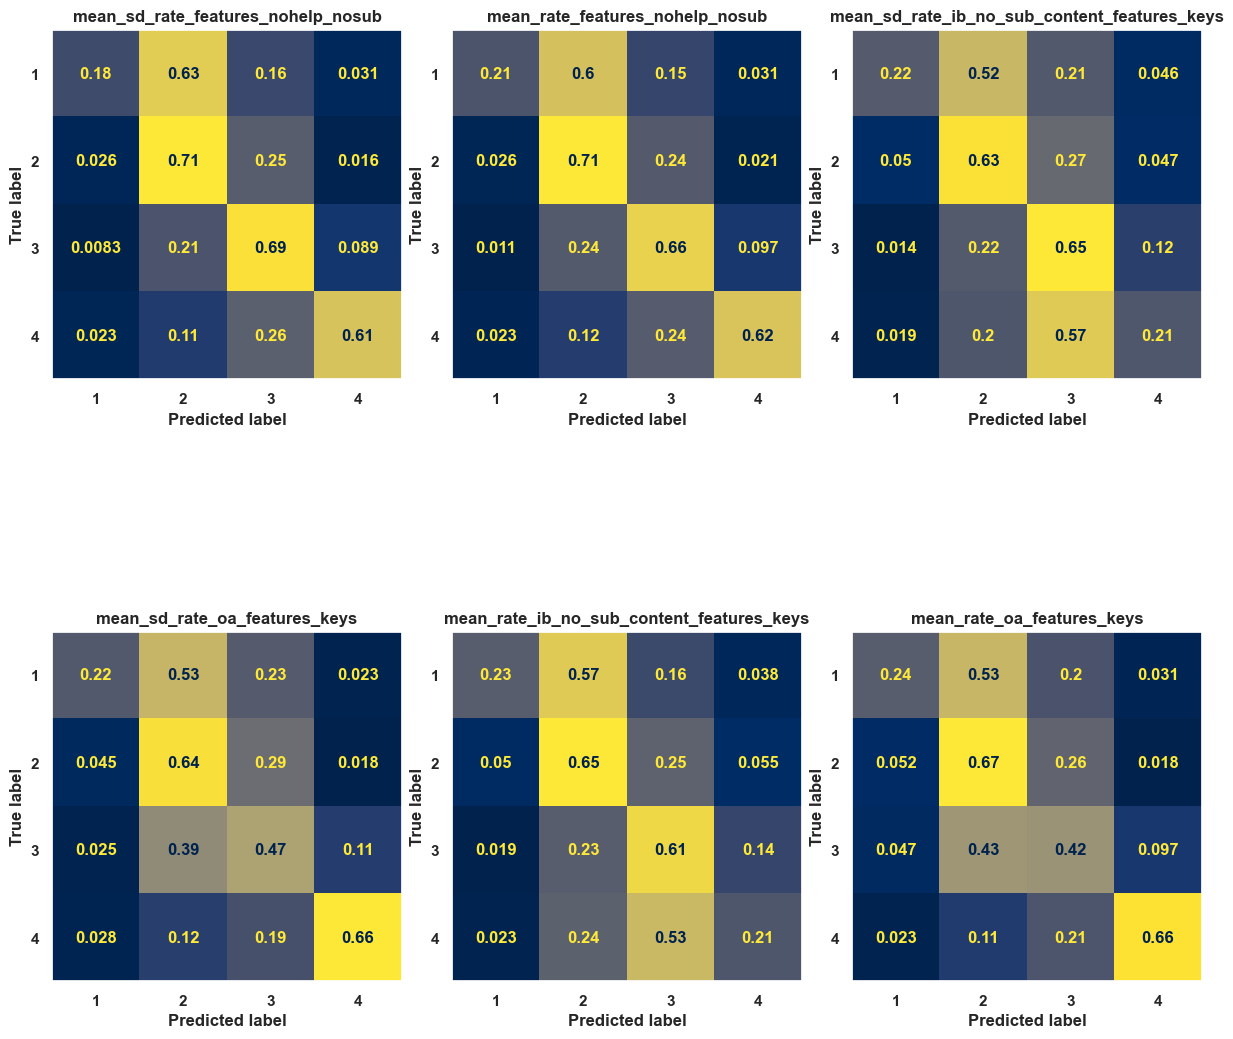

In [152]:
print(f"------------------ Normalized Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(2, 3, constrained_layout=True,figsize=[12,12])
    
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatrelative_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    plt.show()

------------------ Absolute Matrices ------------------
------------------ Level1  ------------------


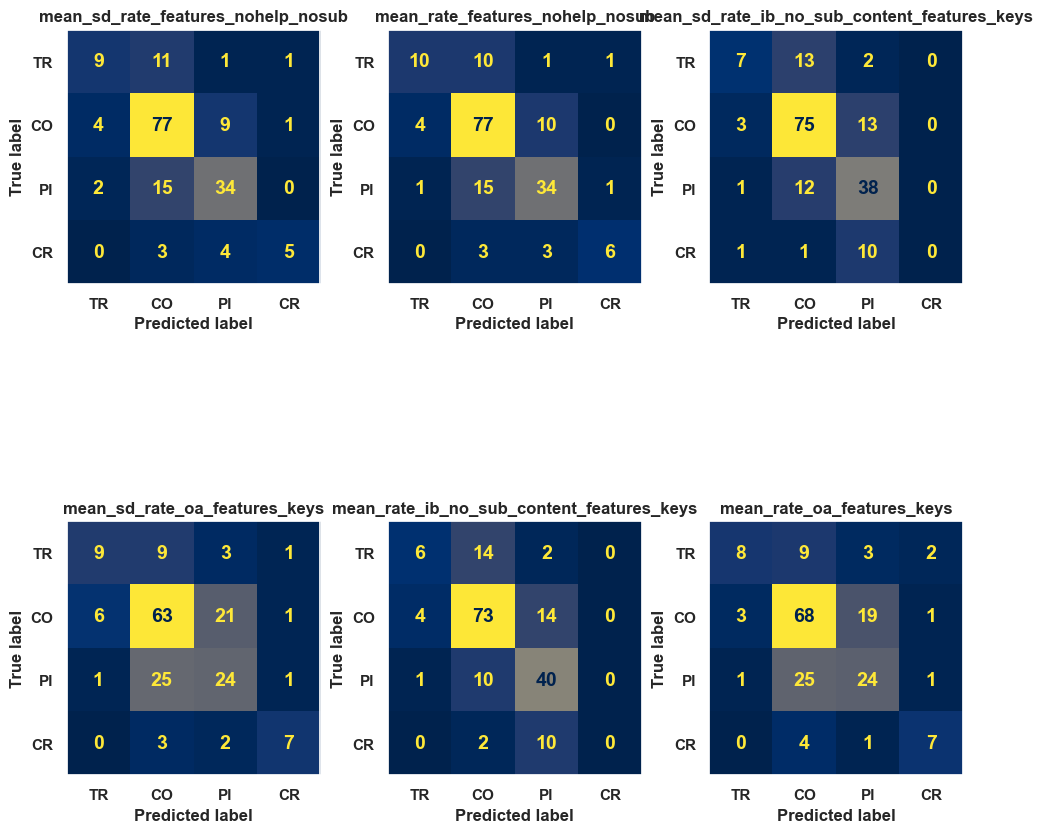

------------------ Level3  ------------------


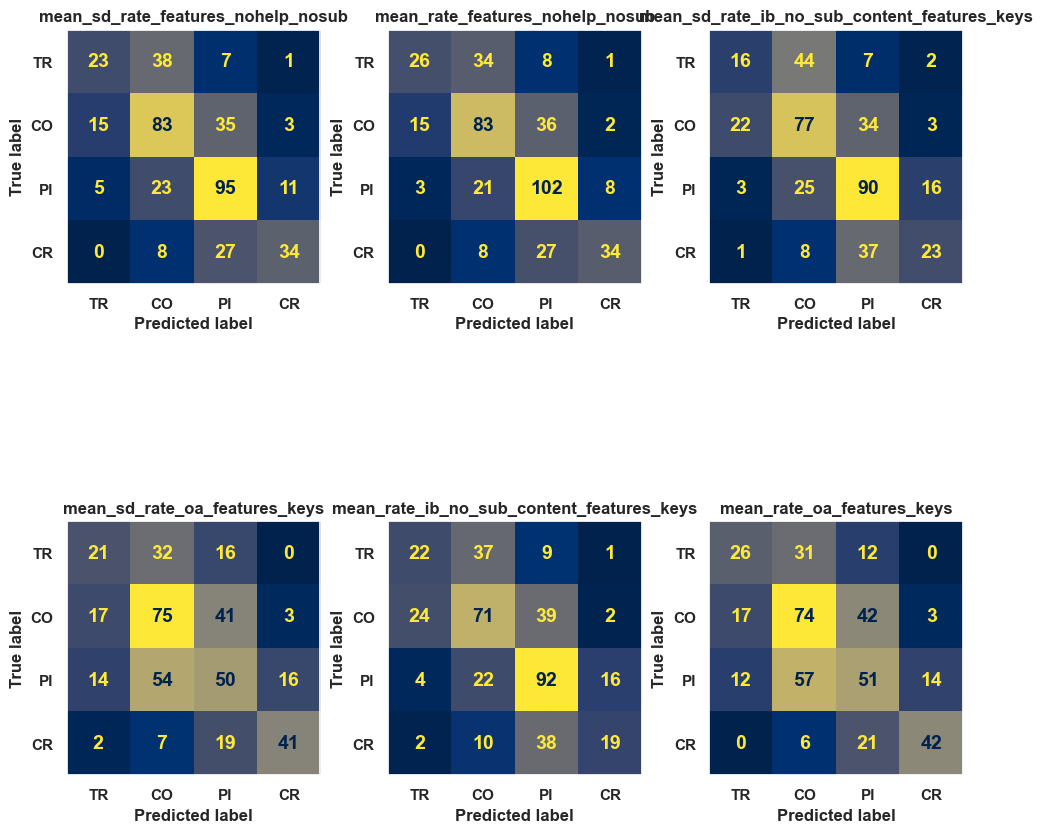

------------------ Level4  ------------------


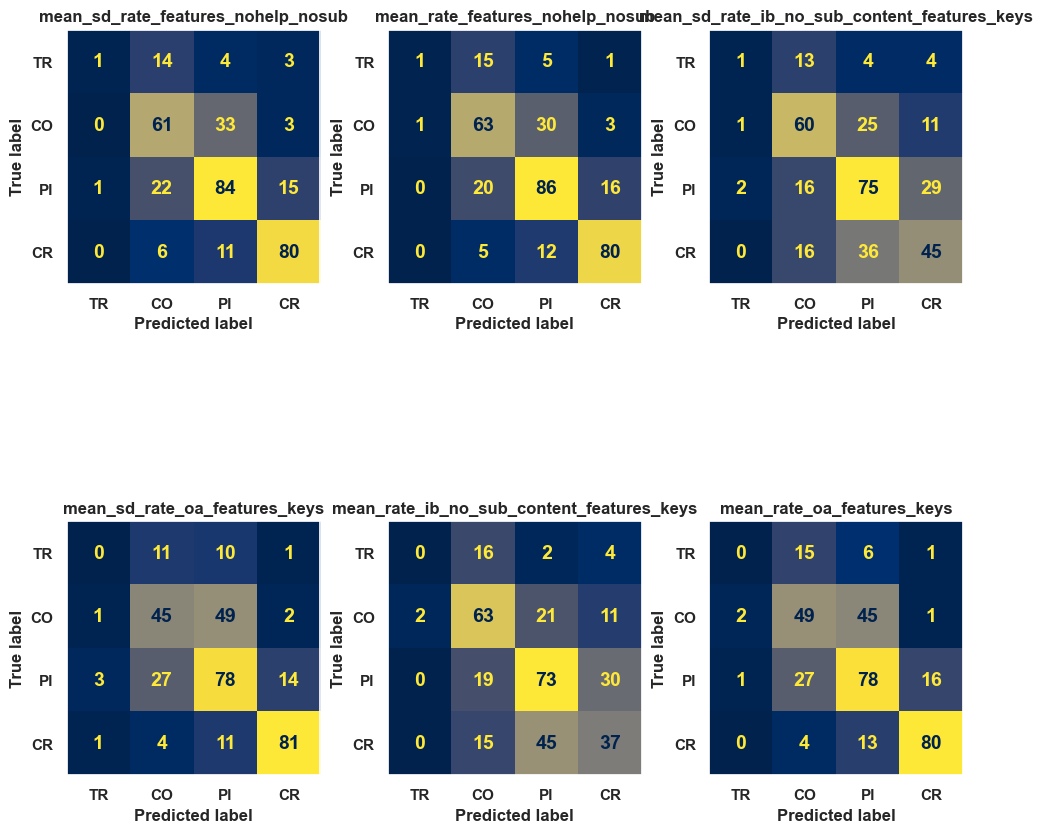

------------------ Level5  ------------------


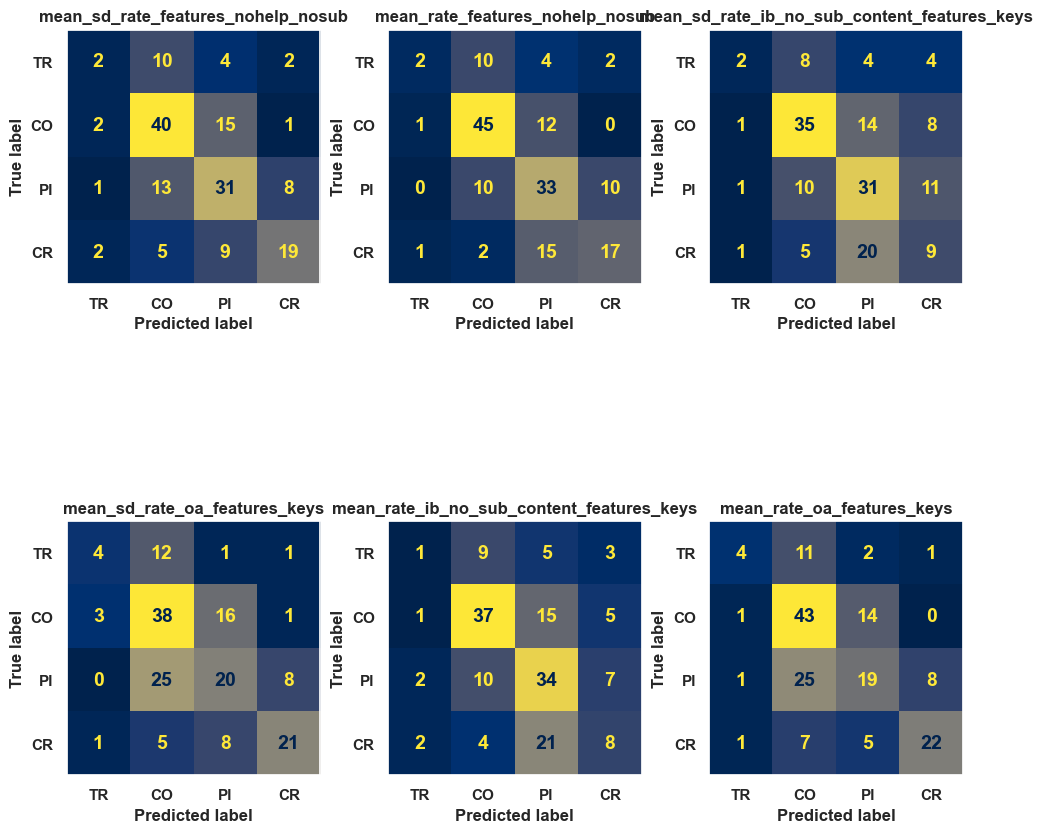

------------------ All_Level  ------------------


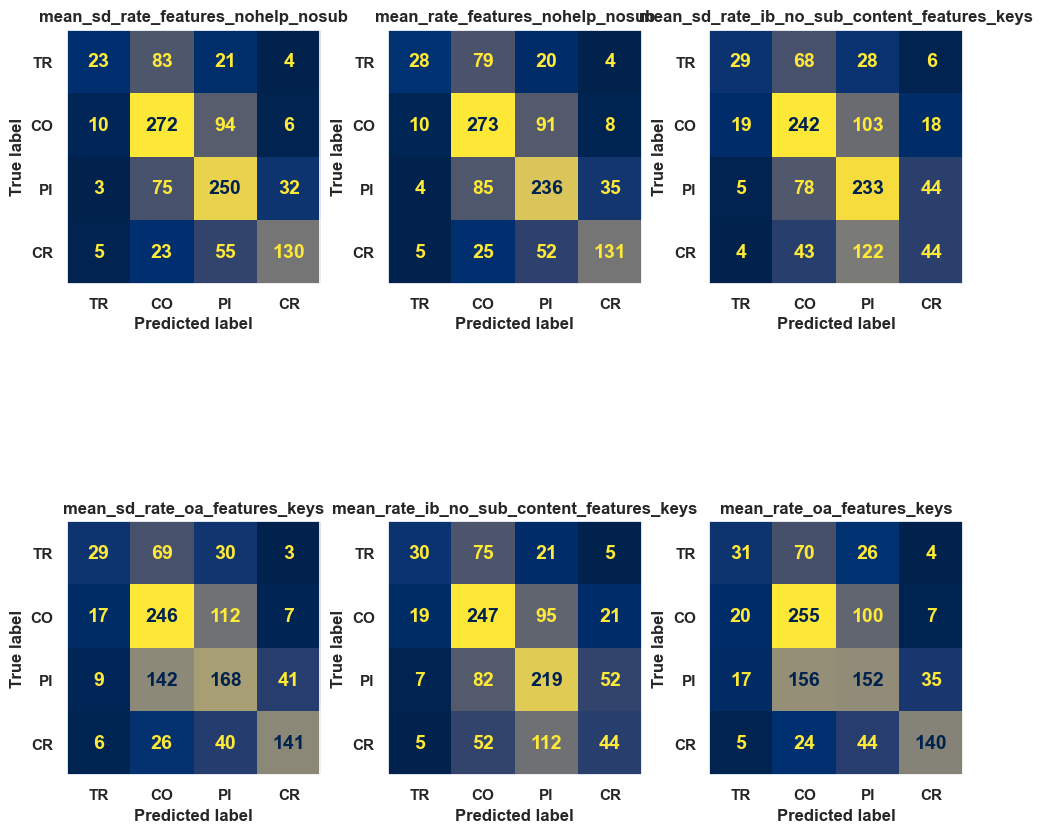

In [153]:
print(f"------------------ Absolute Matrices ------------------")
for level_key in levels_grid_classifier.keys():
    index = 0
    fig, axs = plt.subplots(2,3, constrained_layout=True,figsize=[12,12])
    f"""or subaxs in axs:
        for ax in subaxs: 
            for item in [ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels():
                item.set_fontsize(20)"""
    plt.rcParams["font.size"] = 14.0
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
            
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        col = index % 3
        row = index // 3
        level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], \
                                                colorbar = False, cmap="cividis", normalize=None, \
                                               display_labels=target_names)

        axs[row,col].grid(False)
        axs[row,col].set_title(fset_key,fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
    plt.savefig(f"outputdata/Pyrates_confmatabsolute_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
    fig.tight_layout()
    plt.show()

## 10) Most important features

### 10.1) By perfumation

We compute and export the most important features selected in the best classifier to further understand what the model actually learned.
In our case the best classifiers was Random Forest and feature important is computed using the permutation feature importance feature of Sklearn.

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled : https://scikit-learn.org/stable/modules/permutation_importance.html

/!\ When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.

In [154]:
resimportance = []

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
        print(f"    --------------- {fset_key} ---------------")
        
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)

            level_permutation_importance = permutation_importance(levels_grid_classifier[level_key][fset_key][best_classifier][k], level_train_set_features, level_train_set_labels,scoring="f1_weighted", n_repeats=10,random_state=42, n_jobs=-1)
            resimportance += [{"level_key": level_key, \
                     "features_set": fset_key, \
                     "classifier": best_classifier, \
                     "K": k, \
                     "feature": level_train_set_features.keys()[i],  \
                     "importance": level_permutation_importance.importances_mean[i] } \
                    for i in range(len(level_permutation_importance.importances_mean)) \
                    ]

levels_grid_features_importance = pd.DataFrame.from_records(resimportance) 
print("Done")


------------------ Level1 ------------------
    --------------- mean_sd_rate_features_nohelp_nosub ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_rate_features_nohelp_nosub ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_sd_rate_ib_no_sub_content_features_keys ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_sd_rate_oa_features_keys ---------------
------------------ 0 ------------------
------------------ 1 --------

------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
Done


Display the feature importance values in charts

------------------ Feature importance ------------------
------------------ Level1  ------------------
-------------------------- mean_sd_rate_features_nohelp_nosub  ----------------------------
                             importance
feature                                
CO_avg_for_disp_time           0.191619
GA_avg_function_param_error    0.010857
GA_avg_open_chest_loc_error    0.007661
EX_rate_speed_changed          0.007486
CO_avg_for_simple_impl         0.007184
GA_avg_walk_loc_error          0.005478
CO_std_for_disp_time           0.004423
EX_std_executed                0.004264
GA_std_right_ctr_fun_used      0.003803
EX_avg_syntactic_error         0.003580
-------------------------- mean_rate_features_nohelp_nosub  ----------------------------
                             importance
feature                                
CO_avg_for_disp_time           0.229161
GA_avg_function_param_error    0.027480
EX_avg_syntactic_error         0.021744
EX_avg_executed                0.015

-------------------------- mean_sd_rate_ib_no_sub_content_features_keys  ----------------------------
                            importance
feature                               
CO_avg_condi_disp_time        0.153284
CO_rate_condi_2bran_copied    0.057111
EX_std_executed               0.042869
EX_avg_executed               0.041279
CO_avg_var_disp_time          0.029868
CO_avg_for_disp_time          0.019204
CO_std_for_disp_time          0.017932
CO_std_condi_disp_time        0.013626
CO_rate_pasted                0.011356
CO_rate_code_editor_copied    0.009257
-------------------------- mean_sd_rate_oa_features_keys  ----------------------------
                               importance
feature                                  
CO_avg_string_impl               0.128119
EX_avg_syntactic_error           0.078081
EX_std_syntactic_error           0.023215
CO_avg_else_branch_impl          0.015891
GA_avg_walk_ctr_fun_used         0.013905
GA_avg_read_message_loc_error    0.011543
GA_avg_

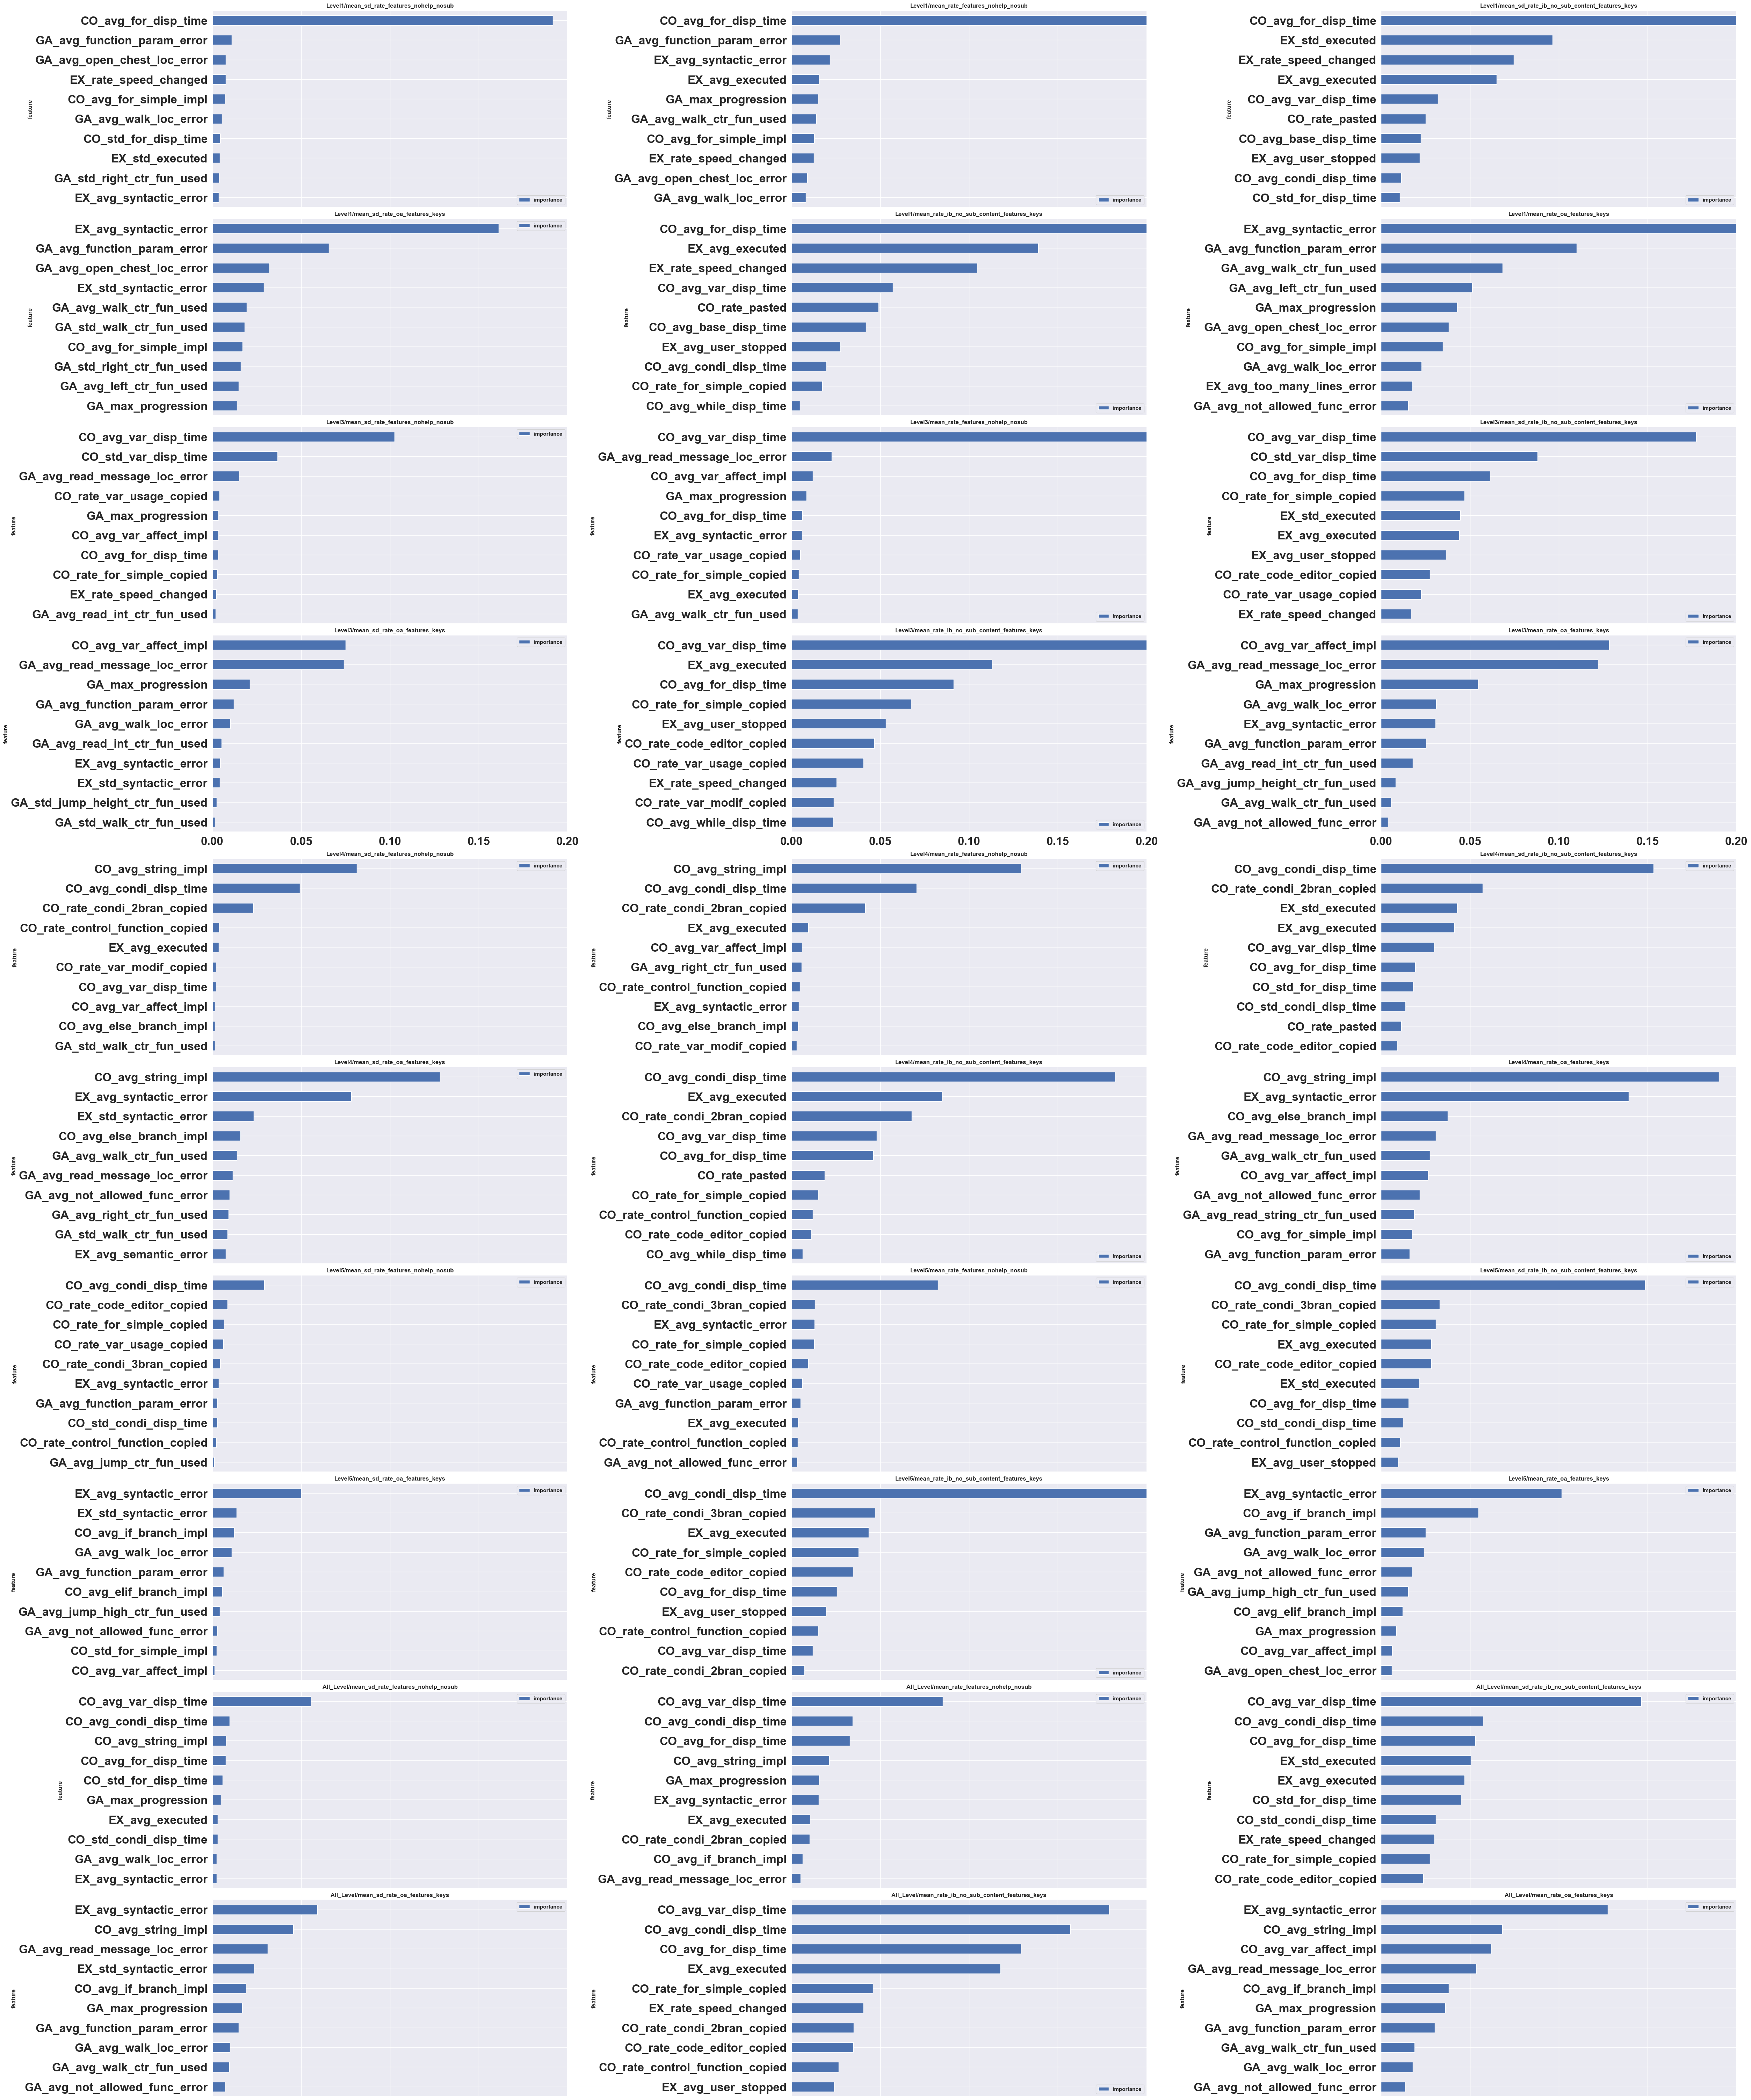

In [155]:
#Feature importance per level and feat set
print(f"------------------ Feature importance ------------------")
fig, axs = plt.subplots(10,3, constrained_layout=True,figsize=[50,60])
index = 0

for level_key in levels_grid_classifier.keys():
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        print(f"-------------------------- {fset_key}  ----------------------------")
        col = index % 3
        row = index // 3
        #level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        #level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        #ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")
        imp = levels_grid_features_importance[(levels_grid_features_importance["level_key"]==level_key) & \
                                      (levels_grid_features_importance["features_set"]==fset_key)]
        imp = imp.groupby(by=["feature"]).mean()
        imp = imp.sort_values(by="importance", ascending=False).head(10).drop("K", axis=1)
        print(imp)
        imp.plot.barh(ax = axs[row,col])
        
        #axs[row,col].grid(False)
        axs[row,col].invert_yaxis()
        axs[row,col].set_xlim([0, 0.2])
        axs[row,col].set_xticks([0,0.05, 0.1,0.15,0.2])
        for label in (axs[row,col].get_xticklabels() + axs[row,col].get_yticklabels()):
            label.set_fontsize(24)
        if row != 3:
            axs[row,col].set_xticklabels(["","","","",""])
        axs[row,col].set_title(f"{level_key}/{fset_key}",fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
plt.savefig(f"outputdata/Pyrates_featureimp_hypertuning_{best_classifier}_{EXPORT_SUFFIX}.png")
plt.show()
    
    

### 10.2) Impurity-based

Random Forest impurity-based feature importances. Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error): https://scikit-learn.org/stable/modules/ensemble.html#random-forest-feature-importance

/!\ Impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.


In [156]:
resimportance = []

for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
        print(f"    --------------- {fset_key} ---------------")
        
        fset_dataframe = level_processed_dataframe[fset_columns]
    
        for k in range(NBFOLDS):
            print(f"------------------ {k} ------------------")      
            (level_train_set_index, level_test_set_index) = cv_split_indices[level_key][k]
            level_train_set = fset_dataframe.iloc[level_train_set_index]
            level_test_set = fset_dataframe.iloc[level_test_set_index]

            #level_features, level_labels, level_groups  = feature_label_group_split(fset_dataframe) #for the baselines
            level_train_set_features, level_train_set_labels, level_train_set_groups  = feature_label_group_split(level_train_set)
            level_test_set_features, level_test_set_labels  = feature_label_split(level_test_set)
            
            level_features_importances = levels_grid_classifier[level_key][fset_key][classifier_name][k][best_classifier_pipeline].feature_importances_
            level_features_names = levels_grid_classifier[level_key][fset_key][classifier_name][k]["features_correlated"].to_keep
            
            #level_features = levels_grid_classifier[level_key][fset_key][classifier_name][0]["data_scaler"].feature_names_in_
            #level_features_importances_series = pd.Series(level_features_importances, index=level_features)
            #level_features_importances_series = level_features_importances_series.sort_values(ascending=False)  
            #level_features_importances_series = level_features_importances_series.head(10)
            #level_MDI_importance = levels_grid_classifier[level_key][fset_key][classifier_name][k][best_classifier_pipeline].feature_importances_
            resimportance += [{"level_key": level_key, \
                     "features_set": fset_key, \
                     "classifier": best_classifier, \
                     "K": k, \
                     "feature": level_features_names[i],  \
                     "importance": level_features_importances[i] } \
                    for i in range(len(level_features_names)) \
                    ]

levels_grid_features_mdi = pd.DataFrame.from_records(resimportance) 
print("Done")


------------------ Level1 ------------------
    --------------- mean_sd_rate_features_nohelp_nosub ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_rate_features_nohelp_nosub ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_sd_rate_ib_no_sub_content_features_keys ---------------
------------------ 0 ------------------
------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
    --------------- mean_sd_rate_oa_features_keys ---------------
------------------ 0 ------------------
------------------ 1 --------

------------------ 1 ------------------
------------------ 2 ------------------
------------------ 3 ------------------
------------------ 4 ------------------
Done


------------------ Feature importance ------------------
------------------ Level1  ------------------
-------------------------- mean_sd_rate_features_nohelp_nosub  ----------------------------
-------------------------- mean_rate_features_nohelp_nosub  ----------------------------
-------------------------- mean_sd_rate_ib_no_sub_content_features_keys  ----------------------------
-------------------------- mean_sd_rate_oa_features_keys  ----------------------------
-------------------------- mean_rate_ib_no_sub_content_features_keys  ----------------------------
-------------------------- mean_rate_oa_features_keys  ----------------------------
------------------ Level3  ------------------
-------------------------- mean_sd_rate_features_nohelp_nosub  ----------------------------
-------------------------- mean_rate_features_nohelp_nosub  ----------------------------
-------------------------- mean_sd_rate_ib_no_sub_content_features_keys  ----------------------------
---------------

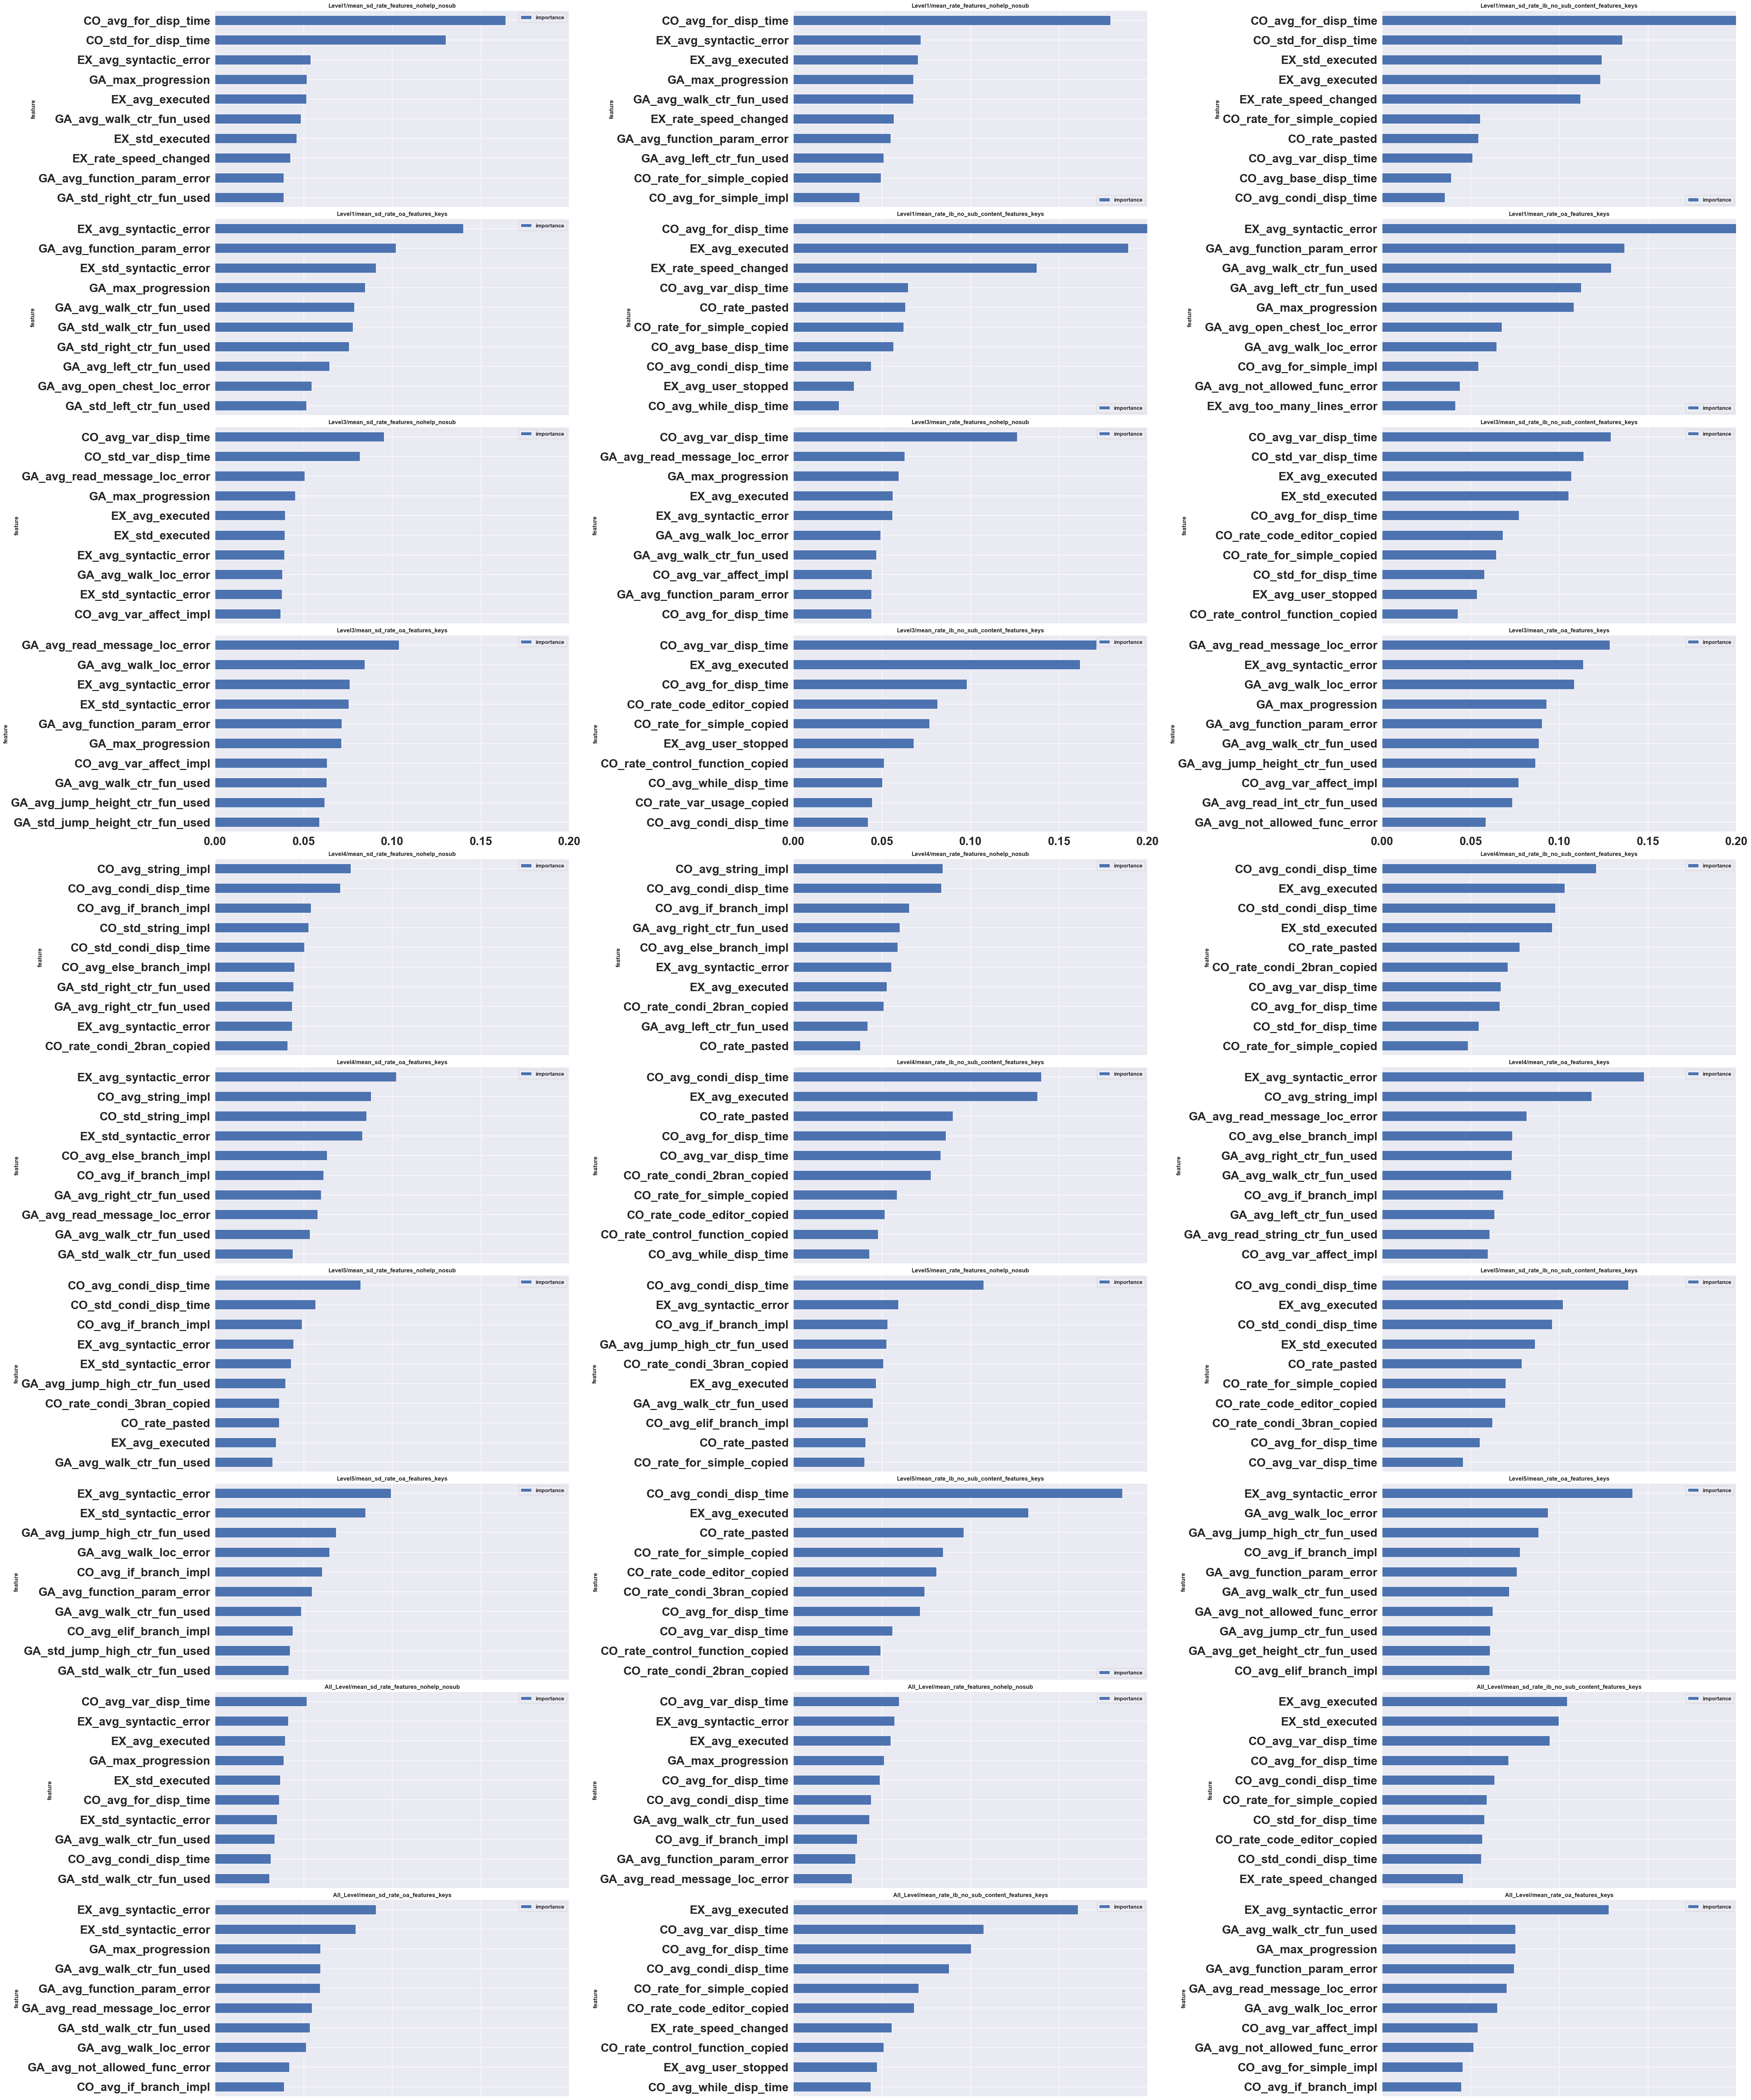

In [157]:
#Feature importance per level and feat set
print(f"------------------ Feature importance ------------------")
fig, axs = plt.subplots(10,3, constrained_layout=True,figsize=[50,60])
index = 0

for level_key in levels_grid_classifier.keys():
    print(f"------------------ {level_key}  ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():
        if "baseline" in fset_key: #ignore feature sets that are just for baseline purposes when taining the ML models
            continue
        if fset_key not in FEATURES_SETS_KEEP_FOR_ML:
            continue #ignored unselected sets
            
        print(f"-------------------------- {fset_key}  ----------------------------")
        col = index % 3
        row = index // 3
        #level_test_set_labels = pred_labels[level_key][fset_key][best_classifier]
        #level_test_set_predictions = pred_results[level_key][fset_key][best_classifier] 
        #ConfusionMatrixDisplay.from_predictions(level_test_set_labels, level_test_set_predictions, ax = axs[row,col], colorbar = False, cmap="cividis", normalize="true")
        imp = levels_grid_features_mdi[(levels_grid_features_mdi["level_key"]==level_key) & \
                                      (levels_grid_features_mdi["features_set"]==fset_key)]
        imp = imp.groupby(by=["feature"]).mean()
        imp = imp.sort_values(by="importance", ascending=False).head(10).drop("K", axis=1)
        imp.plot.barh(ax = axs[row,col])
        
        #axs[row,col].grid(False)
        axs[row,col].invert_yaxis()
        axs[row,col].set_xlim([0, 0.2])
        axs[row,col].set_xticks([0,0.05, 0.1,0.15,0.2])
        for label in (axs[row,col].get_xticklabels() + axs[row,col].get_yticklabels()):
            label.set_fontsize(24)
        if row != 3:
            axs[row,col].set_xticklabels(["","","","",""])
        axs[row,col].set_title(f"{level_key}/{fset_key}",fontweight='bold')
        #sns.heatmap(levels_results_grid_stats[level_key][["precision_m","recall_m","f1_score_m"]], yticklabels= [best_classifier], xticklabels= ["Precision","Recall","F1_score"], vmin=0, vmax=1,cmap="coolwarm", annot=True,fmt=".3g", cbar=False, ax=axs[2*row+1,col])
        index +=1
plt.savefig(f"outputdata/Pyrates_featuremdi_nosmote_grid_{best_classifier}_{EXPORT_SUFFIX}.png")
plt.show()
    
    


# Pickle and CSV dumps

In [158]:
# Models with no hyperparameter tuning
if levels_results is not None:
    levels_results.to_csv(f"outputdata/Pyrates_model_results_notuning_{NBFOLDS}folds{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_notuning{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_results, f)
    

In [159]:
# Models with hyperparameter tuning    
#save results as a pickle and a CSV
if levels_results_grid is not None:
    levels_results_grid.to_csv(f"outputdata/Pyrates_model_results_hypertuning_nogrid_{NBFOLDS}folds_smote_{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_hypertuning{EXPORT_SUFFIX}", 'wb') as f:
        outputall = {
            "grid_results": levels_results_grid,    
            "grid_trained_classifiers": levels_grid_classifier,
            "grid_predictions":pred_results,
            "grid_true_labels": pred_labels
        }
        pickle.dump(outputall, f) 


In [160]:
#feature importance values
"""if levels_grid_features_importance is not None:
    levels_grid_features_importance.to_csv(f"outputdata/Pyrates_model_featureimp_hypertuning_{best_classifier}_{NBFOLDS}folds_{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/levels_results_featuresimportance{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_grid_features_importance, f)"""
        

#feature MDI values
if levels_grid_features_mdi is not None:
    levels_grid_features_mdi.to_csv(f"outputdata/Pyrates_model_featureMDI_grid_nosmote_{best_classifier}_{NBFOLDS}folds_{EXPORT_SUFFIX}.csv", index=False)
    with open(f"pickle/Pyrates_model_featureMDI_grid_nosmote_{EXPORT_SUFFIX}", 'wb') as f:
        pickle.dump(levels_grid_features_importance, f)

# Export Final Estimators

Export the best estimator per level for the best classifiers (in our case Ranfom Forest)

In [161]:
grid_search = GridSearchCV( 
    estimator = random_forest_clf_pipe,
    param_grid= param_grid_rf,
    cv = stratified_group_cross_val,
    verbose = 1,
    scoring ="f1_weighted",
    n_jobs=-1)

levels_best_classifiers = {}
                
for level_key, level_processed_dataframe in levels_processed_dataframes.items():
    print(f"------------------ {level_key} ------------------")
    for fset_key, fset_columns in FEATURES_SETS.items():  
        if fset_key not in ["mean_rate_features_nohelp_nosub"]:
            continue
        print(f"------------------ {fset_key} ------------------")
        fset_dataframe = level_processed_dataframe[fset_columns]
        level_features, level_labels, level_groups = feature_label_group_split(fset_dataframe)
        
        grid_search.fit(level_features,y=level_labels, groups=level_groups)
        
        print(f"Best score: {grid_search.best_score_}")
        print("Best params: ",grid_search.best_params_)
    
        model_filename = f"models/{level_key.lower()}_{fset_key}{EXPORT_SUFFIX}model.joblib"
        with open(model_filename,"wb") as f:
            dill.dump(grid_search.best_estimator_, f) 
            
print("Done")


------------------ Level1 ------------------
------------------ mean_rate_features_nohelp_nosub ------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best score: 0.7111798654749769
Best params:  {'random_forest_clf__max_depth': None, 'random_forest_clf__n_estimators': 100}


FileNotFoundError: [Errno 2] No such file or directory: 'models/level1_mean_rate_features_nohelp_nosub_run10model.joblib'